**Objectifs**

1) - prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation
Votre prédiction se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)

2) - évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

## Imports

In [1]:
# General Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os, pickle
import time
from datetime import datetime
from IPython.display import display
from prettytable import PrettyTable

# Outliers
from sklearn.ensemble import IsolationForest

# OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

# Data scaling
from sklearn.preprocessing import StandardScaler

# Split
from sklearn.model_selection import train_test_split

# Regression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Evaluation
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer # utile ? 

# Warning
import warnings
warnings.filterwarnings('ignore')

# Sommaire
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Préférences d'affichage

In [2]:
# Set display preferences
pd.set_option('display.max_row', 250)
pd.set_option('display.max_column', 100)
pd.set_option('display.precision', 5)

# Target = SiteEnergyUseWN(kBtu)

## Import des données

In [3]:
# Import des données
filepath = 'df'

with open(filepath, 'rb') as f:
    df = pickle.load(f)

# Visualiser les données
df

Latitude  Longitude  NumberofFloors  PropertyGFAParking  \
0      0.45751    0.49213         0.12121             0.00000   
1      0.46183    0.51920         0.11111             0.02939   
3      0.46607    0.50113         0.10101             0.00000   
4      0.46442    0.47560         0.18182             0.12095   
5      0.47548    0.50160         0.02020             0.07257   
...        ...        ...             ...                 ...   
1524   0.15454    0.62698         0.01010             0.00824   
1525   0.09818    0.74910         0.02020             0.00000   
1526   0.76467    1.00000         0.01010             0.00000   
1534   0.72838    0.13025         0.01010             0.00000   
1538   0.43767    0.73037         0.01010             0.00000   

      PropertyGFABuilding(s)  ENERGYSTARScore  SiteEUIWN(kBtu/sf)  \
0                    0.04812          0.59596             0.10103   
1                    0.04816          0.60606             0.11733   
3                    0.03273          0.55556             0.13579   
4                    0.06239          0.74747             0.14226   
5                    0.03203          0.59764             0.16970   
...                      ...              ...                 ...   
1524                 0.02510          0.36364             0.09624   
1525                 0.01212          0.08081             0.22687   
1526                 0.03879          0.65867             0.05321   
1534                 0.00747          0.80766             0.07071   
1538                 0.00931          0.62795             0.11913   

      SourceEUIWN(kBtu/sf)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
0                  0.07288                0.02514         0.01485   
1                  0.06922                0.02921         0.00000   
3                  0.08623                0.02342         0.01641   
4                  0.08303                0.04940         0.00000   
5                  0.12303                0.04241         0.00000   
...                    ...                    ...             ...   
1524               0.04451                0.01410         0.00000   
1525               0.14523                0.01595         0.00000   
1526               0.03962                0.01078         0.00000   
1534               0.05015                0.00334         0.00000   
1538               0.07120                0.00672         0.00000   

      Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  \
0               0.01479           0.00924            0.02038   
1               0.01223           0.03723            0.02410   
3               0.01050           0.01311            0.02334   
4               0.01997           0.06371            0.04110   
5               0.02726           0.03412            0.02459   
...                 ...               ...                ...   
1524            0.00309           0.02079            0.01288   
1525            0.00831           0.01631            0.01102   
1526            0.00734           0.00741            0.00556   
1534            0.00239           0.00285            0.00207   
1538            0.00322           0.00755            0.00501   

      GHGEmissionsIntensity  Building_Age PrimaryPropertyType Neighborhood  \
0                   0.11077       0.76522               Hotel     DOWNTOWN   
1                   0.11193       0.16522               Hotel     DOWNTOWN   
3                   0.18228       0.77391               Hotel     DOWNTOWN   
4                   0.11271       0.30435               Hotel     DOWNTOWN   
5                   0.12126       0.13913               Other     DOWNTOWN   
...                     ...           ...                 ...          ...   
1524                0.11854       0.52174  Mixed Use Property      BALLARD   
1525                0.21026       0.74783           Warehouse      BALLARD   
1526                0.03731       0.01739           Warehouse      BALLARD   
1534              

## Feature selection

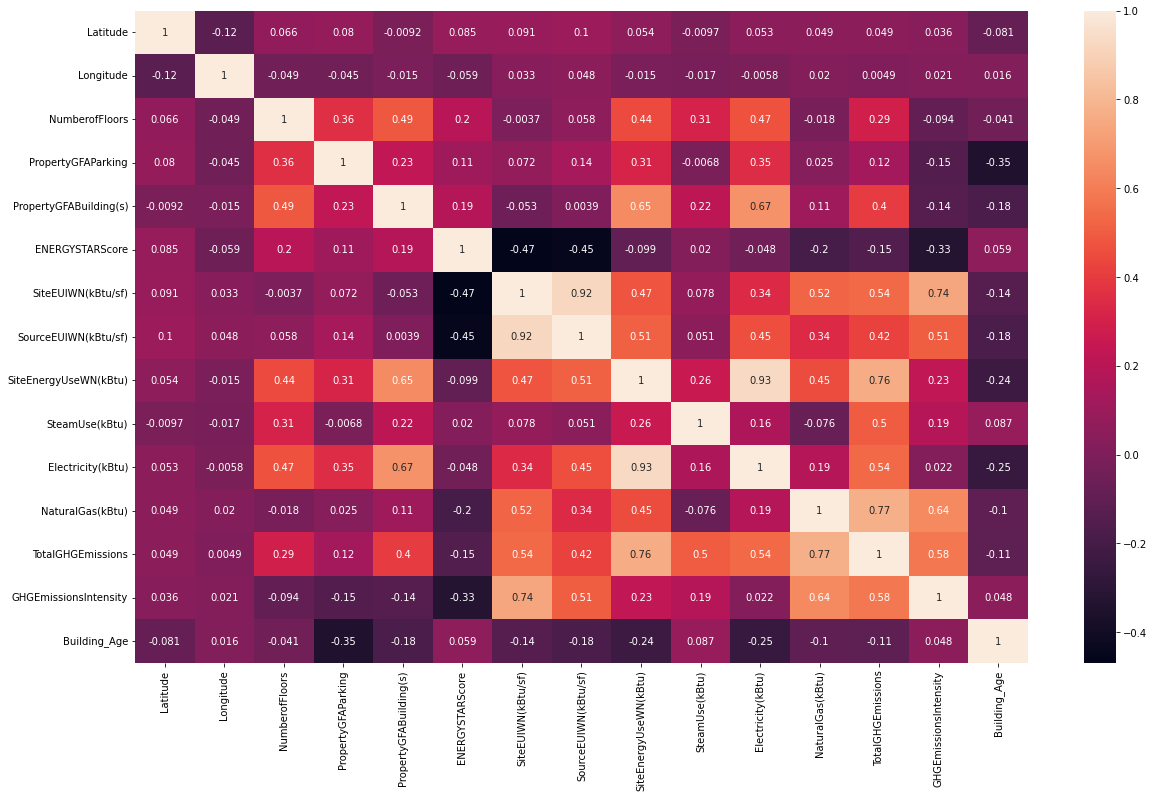

In [4]:
# matrice des correlation
plt.figure(figsize = (20,12))
sns.heatmap(df.corr(), annot = True)
plt.show()

In [5]:
# Lister les colonnes
df.columns

Index(['Latitude', 'Longitude', 'NumberofFloors', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ENERGYSTARScore', 'SiteEUIWN(kBtu/sf)',
       'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'Building_Age', 'PrimaryPropertyType',
       'Neighborhood', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ComplianceStatus'],
      dtype='object')

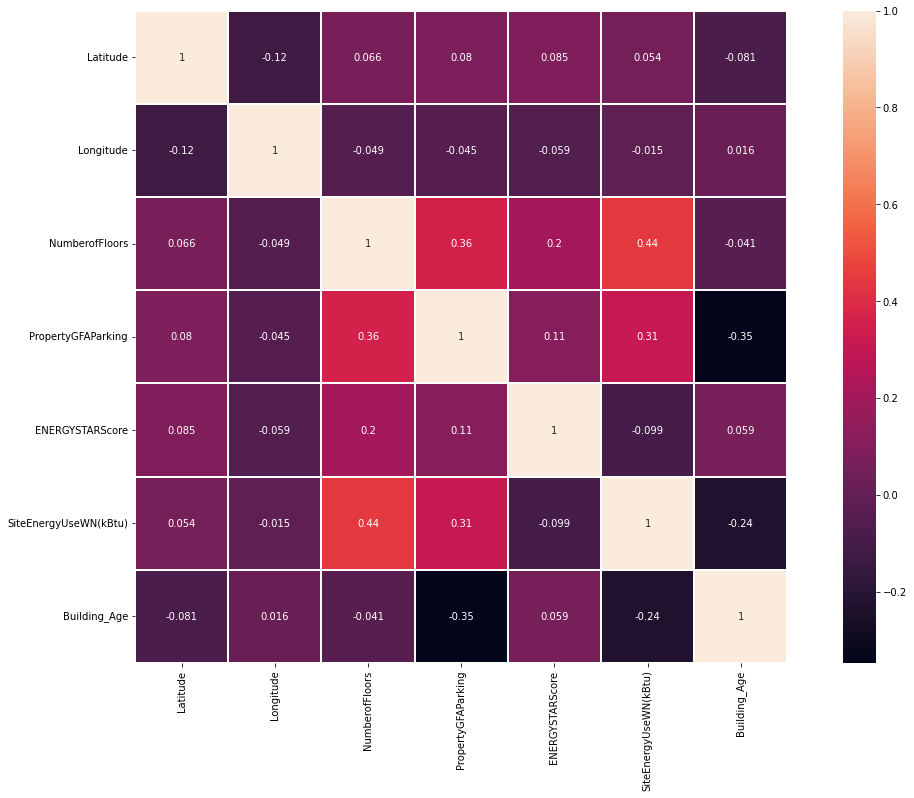

In [6]:
########## FEATURE SELECTION ##########

# https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf
# How does correlation help in feature selection?
# Features with high correlation are more linearly dependent and hence have almost the same effect on the dependent variable.
# So, when two features have high correlation, we can drop one of the two features.

# risque de multicolinearité si on garde les variables fortement correlées
# 'seuil' pris pour high corr ici = 0.80

# d'après matrice de correlations:
features_to_drop = [
    'PropertyGFABuilding(s)',
    'GHGEmissionsIntensity',
    'Electricity(kBtu)',
    'SiteEUIWN(kBtu/sf)', # risque de data linkage
    'TotalGHGEmissions', # autre target, à dropper car high corr avec actuelle target
    'SourceEUIWN(kBtu/sf)',
    'NaturalGas(kBtu)',
    'SteamUse(kBtu)'
    ]

# premier test en droppant tout
# (puis faire un test en droppant variables une par une pour voir leur effet sur modèle)

df.drop(features_to_drop, axis = 1, inplace = True)

# nouvelle matrice des correlation
plt.figure(figsize = (20,12))
sns.heatmap(df.corr(), annot = True, linewidths = 0.1, square = True)
plt.show()

# autre option de feature selection à garder en tête = Variance Threshold

## Encoding

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831 entries, 0 to 1538
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Latitude                      831 non-null    float64
 1   Longitude                     831 non-null    float64
 2   NumberofFloors                831 non-null    float64
 3   PropertyGFAParking            831 non-null    float64
 4   ENERGYSTARScore               831 non-null    float64
 5   SiteEnergyUseWN(kBtu)         831 non-null    float64
 6   Building_Age                  831 non-null    float64
 7   PrimaryPropertyType           831 non-null    object 
 8   Neighborhood                  831 non-null    object 
 9   ListOfAllPropertyUseTypes     831 non-null    object 
 10  LargestPropertyUseType        831 non-null    object 
 11  SecondLargestPropertyUseType  831 non-null    object 
 12  ComplianceStatus              831 non-null    object 
dtypes: f

In [8]:
# attention au data linkage

### a) Variables qualitatives

In [9]:
# get dummies -> méthode ok mais on peut mieux faire
#df = pd.get_dummies(data = df, drop_first = True) # ne pas le faire ici, le faire seulement une fois qu'on a fait tout le traitement nécéssaire
#df.head()

# utiliser autoencoder / onehotencoder (equivalent de get dummies - meilleure methode)

In [10]:
df_quali = df.select_dtypes(include = 'object')
df_quali.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831 entries, 0 to 1538
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   PrimaryPropertyType           831 non-null    object
 1   Neighborhood                  831 non-null    object
 2   ListOfAllPropertyUseTypes     831 non-null    object
 3   LargestPropertyUseType        831 non-null    object
 4   SecondLargestPropertyUseType  831 non-null    object
 5   ComplianceStatus              831 non-null    object
dtypes: object(6)
memory usage: 45.4+ KB


In [11]:
df_quali.columns

Index(['PrimaryPropertyType', 'Neighborhood', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ComplianceStatus'],
      dtype='object')

In [12]:
df_quali

PrimaryPropertyType Neighborhood  \
0                  Hotel     DOWNTOWN   
1                  Hotel     DOWNTOWN   
3                  Hotel     DOWNTOWN   
4                  Hotel     DOWNTOWN   
5                  Other     DOWNTOWN   
...                  ...          ...   
1524  Mixed Use Property      BALLARD   
1525           Warehouse      BALLARD   
1526           Warehouse      BALLARD   
1534               Other      BALLARD   
1538               Other      BALLARD   

                            ListOfAllPropertyUseTypes  \
0                                               Hotel   
1                          Hotel, Parking, Restaurant   
3                                               Hotel   
4                       Hotel, Parking, Swimming Pool   
5                                      Police Station   
...                                               ...   
1524  Non-Refrigerated Warehouse, Other, Retail Store   
1525               Non-Refrigerated Warehouse, Office   
1526                       Non-Refrigerated Warehouse   
1534                        Library, Other - Services   
1538                              Parking, Strip Mall   

          LargestPropertyUseType SecondLargestPropertyUseType ComplianceStatus  
0                          Hotel                      Parking        Compliant  
1                          Hotel                      Parking        Compliant  
3                          Hotel                      Parking        Compliant  
4                          Hotel                      Parking        Compliant  
5                 Police Station                      Parking        Compliant  
...                          ...                          ...              ...  
1524                       Other                 Retail Store        Compliant  
1525  Non-Refrigerated Warehouse                       Office        Compliant  
1526  Non-Refrigerated Warehouse                      Parking        Compliant  
1534                     Library             Other - Services        Compliant  
1538                  Strip Mall                      Parking        Compliant  

[831 rows x 6 columns]

In [13]:
# SIMPLIFIER

# regarder freq des modalités de chaque variable quali avant de faire le onehotencoder

# si freq < 1% -> remplacer par la modalité la plus fréquente (pour enlever modalités par pertinentes et "simplifier" le jeu de données)
# 823 entries -> 1% => 8
# si moins de 8 -> on remplace

# tester d'abord avec 1% pour voir ce que ça donne et ensuite tester avec 5%

In [14]:
# fonction de simplification des données
def simplify(df, seuil):

    """
    df : dataframe
    seuil : seuil de fréquence pour simplifier les données - entre 0 et 100 (int)

    """

  # calculer frequence en fonction du seuil
    seuil_freq = (df.shape[0] * seuil)/100

  # créer df quali simplifié
    df_simplified = df

  # ajouter boucle sur colonnes
    for col in df.columns:

        # print nom de colonne
        print("----------------------------------------------------")
        print(f'- Colonne {col} : ')
        print("----------------------------------------------------")

        # print nombre de valeurs différentes avant simplification :
        nb_valeurs = df[col].nunique()
        print(f'\n{nb_valeurs} valeurs différentes avant simplification')

        # initier compteur
        count = 0

        # identifier valeur la plus frequente
        mostfreq = df[col].value_counts().index[0] # valeur la plus freq = la 1ère
        frequency = df[col].value_counts()

        # value counts des valeurs
        for i, val in enumerate(frequency):

          # identifier valeurs pour lesquelles on a une freq basse
          if val < seuil_freq:
            label = frequency.index[i]
            #print(f'\nLa valeur {label} est peu fréquente et sera remplacée par la valeur {mostfreq}.\n')

            # replace par valeur la plus freq
            df_simplified[col].loc[df_simplified[col] == label] = df[col].loc[df[col] == label].replace({x : mostfreq for x in df[col].loc[df[col] == label]})
            count += 1

        # Compter nombre de valeurs remplacées pour la colonne
        print(f'{count} valeurs ont été remplacées')

        # print nombre de valeurs différentes après simplification :
        nb_valeurs = df[col].nunique()
        print(f'{nb_valeurs} valeurs différentes après simplification\n')

    return df_simplified

In [15]:
df_quali_simplified = simplify(df_quali, 1)

----------------------------------------------------
- Colonne PrimaryPropertyType : 
----------------------------------------------------

21 valeurs différentes avant simplification
7 valeurs ont été remplacées
14 valeurs différentes après simplification

----------------------------------------------------
- Colonne Neighborhood : 
----------------------------------------------------

17 valeurs différentes avant simplification
4 valeurs ont été remplacées
13 valeurs différentes après simplification

----------------------------------------------------
- Colonne ListOfAllPropertyUseTypes : 
----------------------------------------------------

239 valeurs différentes avant simplification
221 valeurs ont été remplacées
18 valeurs différentes après simplification

----------------------------------------------------
- Colonne LargestPropertyUseType : 
----------------------------------------------------

49 valeurs différentes avant simplification
34 valeurs ont été remplacées
15 vale

In [16]:
########## ONE HOT ENCODER ##########

# Visualiser df simplifié
print("----------------------------------------------------")
print('df simplifié')
print("----------------------------------------------------")
display(df_quali_simplified.head())

# OneHotEncoder
enc = OneHotEncoder(categories = 'auto')

for col in df_quali_simplified.columns:
  # Convertir type des colonnes en categories
  df_quali_simplified[col] = df_quali_simplified[col].astype('category')

  # Leur assigner des valeurs numériques et créer nouvelles colonnes
  df_quali_simplified[col] = df_quali_simplified[col].cat.codes

# Appliquer l'encoding
feature_arr = enc.fit_transform(df_quali_simplified).toarray()

feature_labels = enc.get_feature_names_out(df_quali.columns)

# Recréer un dataframe avec les données encodées
features = pd.DataFrame(feature_arr, columns = feature_labels)
print("----------------------------------------------------")
print('df encodé')
print("----------------------------------------------------")
display(features.head())

----------------------------------------------------
df simplifié
----------------------------------------------------


PrimaryPropertyType Neighborhood ListOfAllPropertyUseTypes  \
0               Hotel     DOWNTOWN                     Hotel   
1               Hotel     DOWNTOWN           Office, Parking   
3               Hotel     DOWNTOWN                     Hotel   
4               Hotel     DOWNTOWN           Office, Parking   
5               Other     DOWNTOWN           Office, Parking   

  LargestPropertyUseType SecondLargestPropertyUseType ComplianceStatus  
0                  Hotel                      Parking        Compliant  
1                  Hotel                      Parking        Compliant  
3                  Hotel                      Parking        Compliant  
4                  Hotel                      Parking        Compliant  
5                 Office                      Parking        Compliant

----------------------------------------------------
df encodé
----------------------------------------------------


PrimaryPropertyType_0  PrimaryPropertyType_1  PrimaryPropertyType_2  \
0                    0.0                    1.0                    0.0   
1                    0.0                    1.0                    0.0   
2                    0.0                    1.0                    0.0   
3                    0.0                    1.0                    0.0   
4                    0.0                    0.0                    0.0   

   PrimaryPropertyType_3  PrimaryPropertyType_4  PrimaryPropertyType_5  \
0                    0.0                    0.0                    0.0   
1                    0.0                    0.0                    0.0   
2                    0.0                    0.0                    0.0   
3                    0.0                    0.0                    0.0   
4                    0.0                    0.0                    0.0   

   PrimaryPropertyType_6  PrimaryPropertyType_7  PrimaryPropertyType_8  \
0                    0.0                    0.0                    0.0   
1                    0.0                    0.0                    0.0   
2                    0.0                    0.0                    0.0   
3                    0.0                    0.0                    0.0   
4                    1.0                    0.0                    0.0   

   PrimaryPropertyType_9  PrimaryPropertyType_10  PrimaryPropertyType_11  \
0                    0.0                     0.0                     0.0   
1                    0.0                     0.0                     0.0   
2                    0.0                     0.0                     0.0   
3                    0.0                     0.0                     0.0   
4                    0.0                     0.0                     0.0   

   PrimaryPropertyType_12  PrimaryPropertyType_13  Neighborhood_0  \
0                     0.0                     0.0             0.0   
1                     0.0                     0.0             0.0   
2                     0.0                     0.0             0.0   
3                     0.0                     0.0             0.0   
4                     0.0                     0.0             0.0   

   Neighborhood_1  Neighborhood_2  Neighborhood_3  Neighborhood_4  \
0             0.0             0.0             1.0             0.0   
1             0.0             0.0             1.0             0.0   
2             0.0             0.0             1.0             0.0   
3             0.0             0.0             1.0             0.0   
4             0.0             0.0             1.0             0.0   

   Neighborhood_5  Neighborhood_6  Neighborhood_7  Neighborhood_8  \
0             0.0             0.0             0.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             0.0             0.0             0.0   

   Neighborhood_9  Neighborhood_10  Neighborhood_11  Neighborhood_12  \
0             0.0              0.0              0.0              0.0   
1             0.0              0.0              0.0              0.0   
2             0.0              0.0              0.0              0.0   
3             0.0              0.0              0.0              0.0   
4             0.0              0.0              0.0              0.0   

   ListOfAllPropertyUseTypes_0  ListOfAllPropertyUseTypes_1  \
0                          0.0                          1.0   
1                          0.0                          0.0   
2                          0.0                          1.0   
3                          0.0                          0.0   
4                          0.0                          0.0   

   ListOfAllPropertyUseTypes_2  ListOfAllPropertyUseTypes_3  \
0                          0.0                          0.0   
1                          0

### b) Variables quantitatives


 Colonne NumberofFloors: 



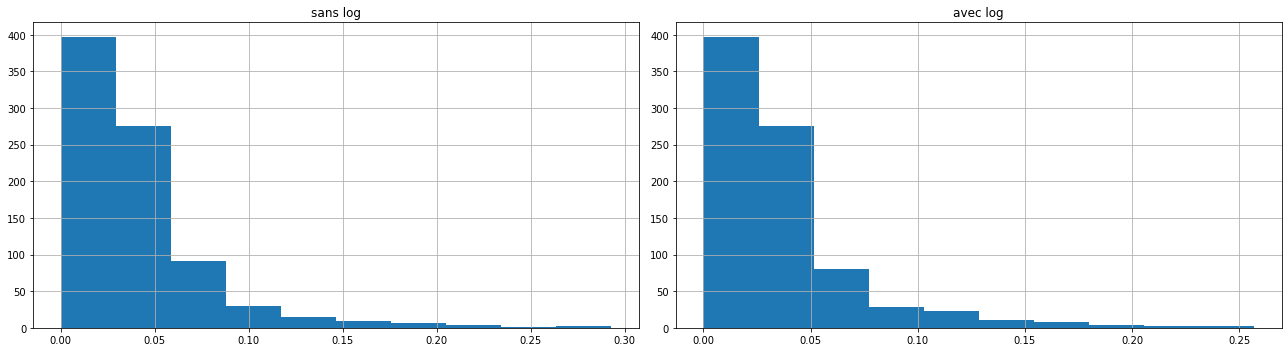


 Colonne PropertyGFAParking: 



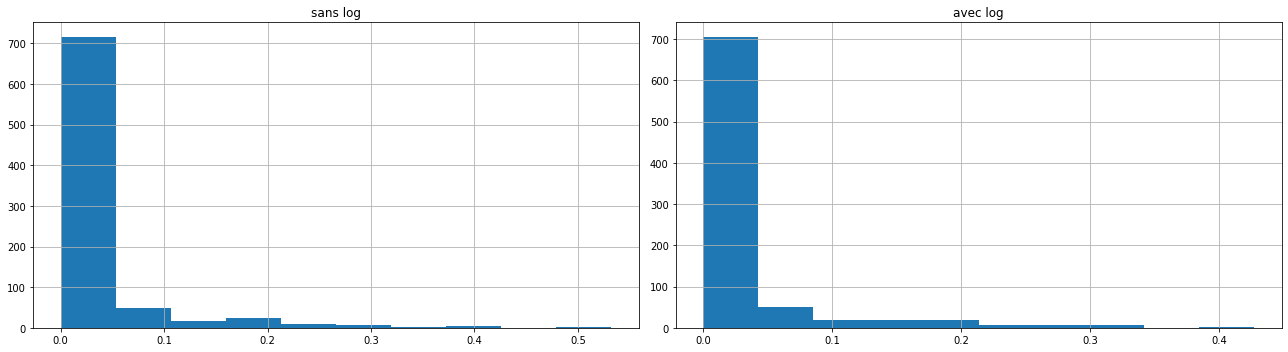


 Colonne ENERGYSTARScore: 



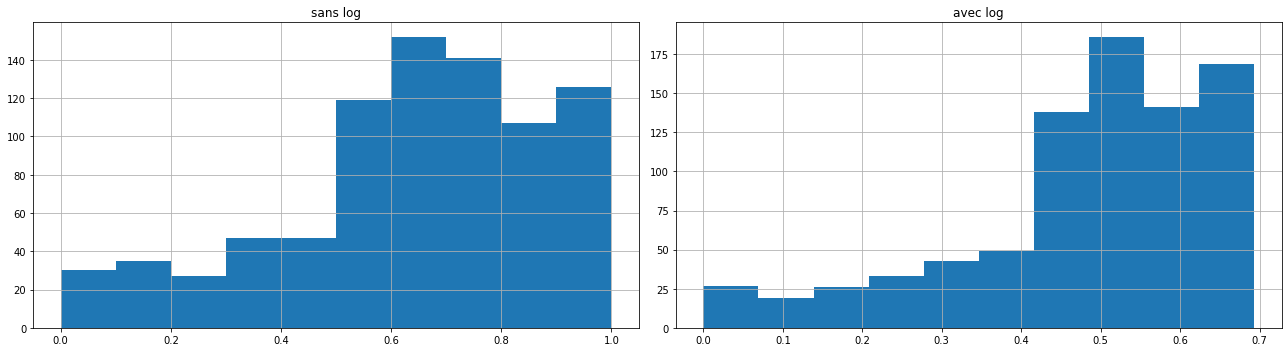


 Colonne SiteEnergyUseWN(kBtu): 



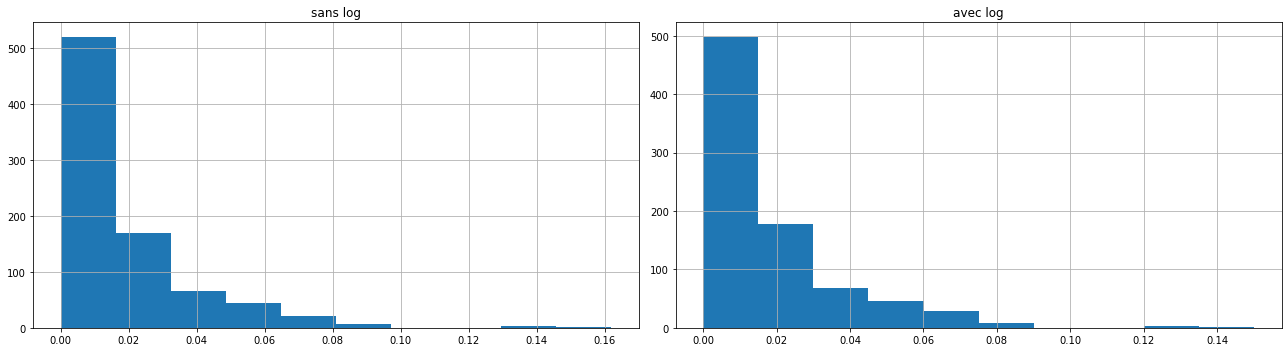


 Colonne Building_Age: 



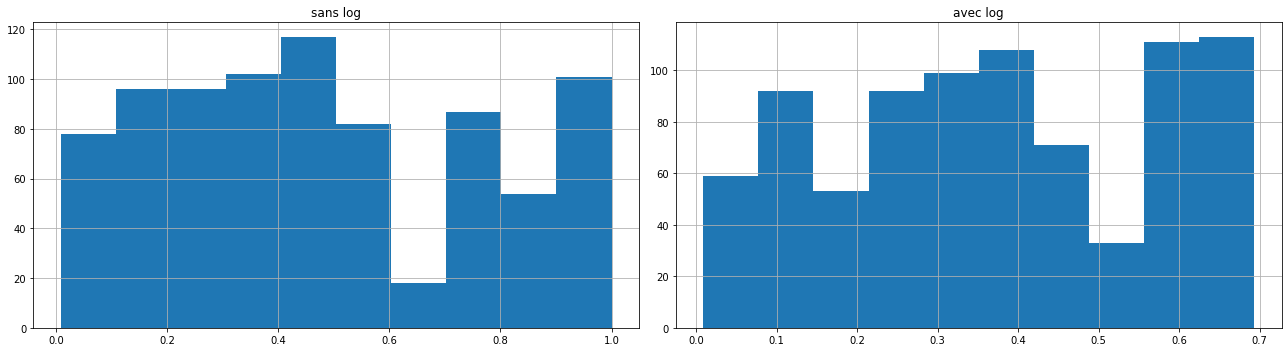

In [17]:
########## VISUALISATION LOG ##########

# Selectionner variables quantitatives uniquement
df_quanti = df.select_dtypes(include = 'float')

# Lister les colonnes qu'on veut visualiser
col = ['NumberofFloors', 'PropertyGFAParking',
       'ENERGYSTARScore', 
       'SiteEnergyUseWN(kBtu)', 
       'Building_Age']

# Visualiser l'effet du log sur chaque variable
for i in col:
    
    print(f'\n Colonne {i}: \n')
    
    # plot valeurs avant log
    plt.figure(figsize = (18, 5))
    plt.subplot(1, 2, 1)
    plt.grid()
    plt.hist(df_quanti[i])
    plt.title('sans log')
    
    # plot valeurs après log
    plt.subplot(1, 2, 2)
    plt.grid()
    plt.hist(np.log(df_quanti[i] + 1))
    plt.title('avec log')
    
    plt.tight_layout()
    plt.show()

In [18]:
########## TRANSFORMATION LOG ##########

# si intervalle de variation n'est pas très grand (tous les points concentrés) -> passer au log pour voir la vraie distribution
# par contre si on voit bien la variation, pas besoin de passer au log

# selectionner colonnes pour lesquelles on va faire le log
col_log = ['NumberofFloors', 'PropertyGFAParking',
           'SiteEnergyUseWN(kBtu)', 
           'Building_Age']

# appliquer la transformation log: df[log de nom de la variable] = np.log(df[nom de la variable])
for i in col_log:
    df_quanti[i] = np.log(df_quanti[i] + 1) # pour ne pas faire log(0)
    
# Visualiser le résultat
display(df_quanti.head())

Latitude  Longitude  NumberofFloors  PropertyGFAParking  ENERGYSTARScore  \
0   0.45751    0.49213         0.11441             0.00000          0.59596   
1   0.46183    0.51920         0.10536             0.02896          0.60606   
3   0.46607    0.50113         0.09623             0.00000          0.55556   
4   0.46442    0.47560         0.16705             0.11418          0.74747   
5   0.47548    0.50160         0.02000             0.07005          0.59764   

   SiteEnergyUseWN(kBtu)  Building_Age  
0                0.02482       0.56827  
1                0.02879       0.15291  
3                0.02315       0.57319  
4                0.04822       0.26570  
5                0.04153       0.13027

In [19]:
########## CONCATENATION ##########
# concatener données qualitatives et quantitatives transformées

features = features.reset_index()
df_quanti = df_quanti.reset_index()

df = pd.concat([features, df_quanti], axis = 1)
df.head()

index  PrimaryPropertyType_0  PrimaryPropertyType_1  PrimaryPropertyType_2  \
0      0                    0.0                    1.0                    0.0   
1      1                    0.0                    1.0                    0.0   
2      2                    0.0                    1.0                    0.0   
3      3                    0.0                    1.0                    0.0   
4      4                    0.0                    0.0                    0.0   

   PrimaryPropertyType_3  PrimaryPropertyType_4  PrimaryPropertyType_5  \
0                    0.0                    0.0                    0.0   
1                    0.0                    0.0                    0.0   
2                    0.0                    0.0                    0.0   
3                    0.0                    0.0                    0.0   
4                    0.0                    0.0                    0.0   

   PrimaryPropertyType_6  PrimaryPropertyType_7  PrimaryPropertyType_8  \
0                    0.0                    0.0                    0.0   
1                    0.0                    0.0                    0.0   
2                    0.0                    0.0                    0.0   
3                    0.0                    0.0                    0.0   
4                    1.0                    0.0                    0.0   

   PrimaryPropertyType_9  PrimaryPropertyType_10  PrimaryPropertyType_11  \
0                    0.0                     0.0                     0.0   
1                    0.0                     0.0                     0.0   
2                    0.0                     0.0                     0.0   
3                    0.0                     0.0                     0.0   
4                    0.0                     0.0                     0.0   

   PrimaryPropertyType_12  PrimaryPropertyType_13  Neighborhood_0  \
0                     0.0                     0.0             0.0   
1                     0.0                     0.0             0.0   
2                     0.0                     0.0             0.0   
3                     0.0                     0.0             0.0   
4                     0.0                     0.0             0.0   

   Neighborhood_1  Neighborhood_2  Neighborhood_3  Neighborhood_4  \
0             0.0             0.0             1.0             0.0   
1             0.0             0.0             1.0             0.0   
2             0.0             0.0             1.0             0.0   
3             0.0             0.0             1.0             0.0   
4             0.0             0.0             1.0             0.0   

   Neighborhood_5  Neighborhood_6  Neighborhood_7  Neighborhood_8  \
0             0.0             0.0             0.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             0.0             0.0             0.0   

   Neighborhood_9  Neighborhood_10  Neighborhood_11  Neighborhood_12  \
0             0.0              0.0              0.0              0.0   
1             0.0              0.0              0.0              0.0   
2             0.0              0.0              0.0              0.0   
3             0.0              0.0              0.0              0.0   
4             0.0              0.0              0.0              0.0   

   ListOfAllPropertyUseTypes_0  ListOfAllPropertyUseTypes_1  \
0                          0.0                          1.0   
1                          0.0                          0.0   
2                          0.0                          1.0   
3                          0.0                          0.0   
4                          0.0                          0.0   

   ListOfAllPropertyUseTypes_2  ListOfAllPropertyUseTypes_3  \
0                          0.0                   

In [20]:
########## EVALUATION ##########
# créer listes pour storer les scores au fur et à mesure

model = [] # nom du modèle
default_best = [] # default ou best
temps_execution = [] # temps d'execution
score_mae = [] # mae
score_mse = [] # mse
score_rmse = [] # rmse
score_r2_train = [] # r2
score_r2_test = [] # r2

In [23]:
########## EVALUATION ##########

def model_evaluation(model_name, model_type, y_train, y_test, y_predtrain, y_predtest, temps):
    
    """
    model_name : nom du modèle à évaluer
    model, model_type, temps_execution, score_mse, score_rmse, score_r2 : listes pour ajouter les valeurs

    """
    global model, default_best, temps_execution, score_mae, score_mse, score_rmse, score_r2_train, score_r2_test
    
    # Nom du modèle
    model.append(model_name)
    
    # 'Type' (Default ou Best)
    default_best.append(model_type)

    # Temps d'execution (s)
    temps_execution.append(round(temps, 3))
    
    # MAE
    # mae = Mean absolute error
    # moyenne arithmétique des valeurs absolues des écarts
    mae = mean_absolute_error(y_test, y_predtest)
    score_mae.append(round(mae, 2))

    # MSE
    # mse = moyenne arithmétique des carrés des écarts entre prévisions du modèle et observations
    # but = minimiser cette valeur dans le cadre d'une régression
    mse = mean_squared_error(y_test, y_predtest)
    score_mse.append(round(mse, 2))

    # RMSE
    # rmse = erreur quadratique moyenne = écart-type des résidus (erreurs de prévision)
    # à interpreter en reliant avec variance des données
    rmse = np.sqrt(mse)
    score_rmse.append(round(rmse, 2))

    # R2 
    # coefficient de détermination 
    # explique dans quelle mesure la variance totale de la variable dépendante peut être réduite en utilisant 
    # la régression des moindres carrés
    r2_train = r2_score(y_train, y_predtrain)
    r2_test = r2_score(y_test, y_predtest)
    score_r2_train.append(round(r2_train, 2))
    score_r2_test.append(round(r2_test, 2))

    # si rmse très faible et r2 quasi égal à 1 -> surement signe de data linkage

In [24]:
# FAIRE FONCTIONS POUR GRIDSEARCH, COURBE APPRENTISSAGE ETC

## Data preparation

In [25]:
########## TARGET ##########

# Separating features X and labels y

# target = consommation en energie
# (seconde target = SiteEnergyUseWN(kBtu) -> cf autre notebook)

X = df.drop(['SiteEnergyUseWN(kBtu)', 'index'], axis = 1)
y = df['SiteEnergyUseWN(kBtu)']

In [26]:
########## DATA SCALING ##########

#It exists many methods to scale your data but the most popular are:
#- StandardScaler: standardizes features by removing the mean and dividing by the Standard Deviation.
#- MinMaxScaler: standardizes features such that it is in a given range ([0-1] per default). For each feature, it removes XMin_feature and divides by (XMax_feature - XMin_feature)
#- Normalize (with L2 norm): scales samples individually to unit L2 norm.

# Initier le scaler
scaler = StandardScaler()

# scaler variables
scaler.fit(X, y)
X_scaled = scaler.transform(X)

In [27]:
########## TRAIN TEST SPLIT ##########
# Separer les données en un train_set et un test_set

X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 10) # pour 'contrôler' le mélange aléatoire des données avant le split

print("Le dataset d'entraînement contient {} lignes".format(len(X_train)))
print("Le dataset de test contient {} lignes".format(len(X_test)))

Le dataset d'entraînement contient 581 lignes
Le dataset de test contient 250 lignes


In [28]:
########## CROSS VALIDATION ##########

# -> consiste à entrainer puis valider notre modèle sur plusieurs découpes possibles du train set
# cv = nombre de splits (de découpes) qu'on veut dans notre cross validation
# prendre nombre impair comme ça on est sûrs d'avoir une réponse (et non un résultat ex aequo)

# ici on fera la validation via la grid search

## Modèle 1 - Regression linéaire

In [29]:
########## Linear Regression Default Params ##########

# début de l'execution
start = time.time()

# Instancier le modèle
lr = LinearRegression()

# Entrainer le modèle
lr.fit(X_train, y_train)

# fin de l'execution
end = time.time()
temps = end - start

# Score
print(f'Coefficient de détermination (R2) = {lr.score(X_test, y_test)}')

# Predire
y_pred_test_default = lr.predict(X_test)
y_pred_train_default = lr.predict(X_train)

Coefficient de détermination (R2) = -2.6663760830374774e+25


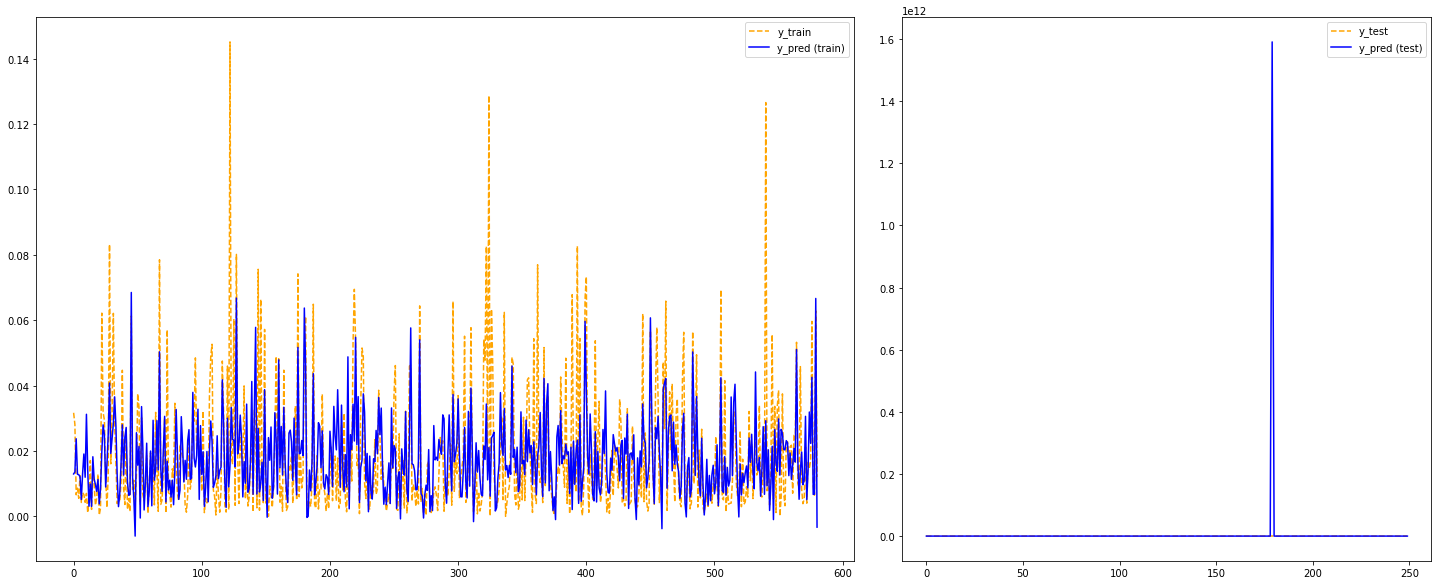

In [30]:
# Plot prédictions

plt.figure(figsize = (25, 10))

ax1 = plt.subplot2grid((1, 5), (0, 0), colspan = 3)
ax1.plot(y_train.values, color = 'orange', linestyle = '--', label = 'y_train')
ax1.plot(y_pred_train_default, color = 'blue', label = 'y_pred (train)')
plt.legend(loc = "best")

ax2 = plt.subplot2grid((1, 5), (0, 3), colspan = 2)
ax2.plot(y_test.values, color = 'orange', linestyle = '--', label = 'y_test')
ax2.plot(y_pred_test_default, color = 'blue', label = 'y_pred (test)')
plt.legend(loc = "best")

plt.show()

In [31]:
########## EVALUATION ##########

model_evaluation(model_name = 'Linear regression', 
                 model_type = 'Default', 
                 y_train = y_train, 
                 y_test = y_test, 
                 y_predtrain = y_pred_train_default, 
                 y_predtest = y_pred_test_default, 
                 temps = temps)

In [32]:
%%time

########## GRIDSEARCH CV ##########
# -> construit une grille de modèles avec toutes les combinaisons d'hyperparamètres présents dans "param_grid"

# début de l'execution
start = time.time()

# Modèle
lr = LinearRegression()

# Hyperparamètres et valeurs à tester
param_grid = {'fit_intercept': [True, False], # default = True
              'copy_X': [True, False], # default = True
              'n_jobs' : [1, 2, 3, 4, 5, None], # default = None
              'positive': [True, False] # default = False
             }

# Grid Search CV
grid = GridSearchCV(lr,
                    param_grid,
                    scoring = 'neg_mean_squared_error',
                    cv = 5,
                    verbose = 1,
                    n_jobs = -1
                   )

# On entraîne la grille 
grid.fit(X_train, y_train)

# fin de l'execution
end = time.time()
temps = end - start

# Meilleur score obtenu: best_score_
print(f'\nBest score = {grid.best_score_}')

# Optimal hyperparameters: best_params_
display(grid.best_params_)

# Sauvegarder le meilleur modèle
best_lr = grid.best_estimator_

# Tester le meilleur modèle sur données test
print(f'Coefficient de détermination (R2) = {best_lr.score(X_test, y_test)}\n')

# Predire
y_pred_test_best = best_lr.predict(X_test)
y_pred_train_best = best_lr.predict(X_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best score = -0.00034407986188187035


{'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'positive': True}

Coefficient de détermination (R2) = 0.11417442114217247

CPU times: user 156 ms, sys: 96.2 ms, total: 252 ms
Wall time: 1.66 s


Quantités de données à utiliser pour l'entrainement (10 lots): [ 92 134 175 216 257 299 340 381 422 464]


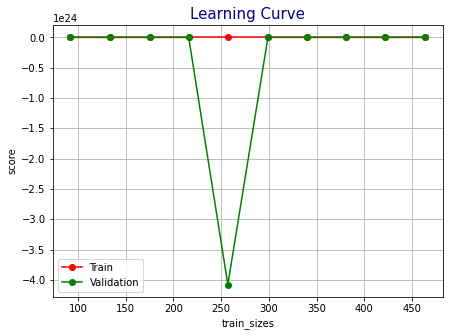

In [33]:
# Courbe d'apprentissage (learning curve)
# montre l'évolution des performances du modèle en fonction de la quantité de données qu'on lui fournit

N, train_score, val_score = learning_curve(best_lr, X_train, y_train, train_sizes = np.linspace(0.2, 1.0, 10), cv = 5)

# Train sizes
print(f"Quantités de données à utiliser pour l'entrainement (10 lots): {N}")

# Learning curve
plt.figure(figsize = (7, 5))
plt.grid()
plt.plot(N, train_score.mean(axis = 1), 'o-', color = 'r', label = 'Train')
plt.plot(N, val_score.mean(axis = 1), 'o-', color  = 'g', label = 'Validation')
plt.title ('Learning Curve', fontsize = 15, color = 'darkblue')
plt.legend(loc = 'best')
plt.xlabel('train_sizes')
plt.ylabel('score')
plt.show()

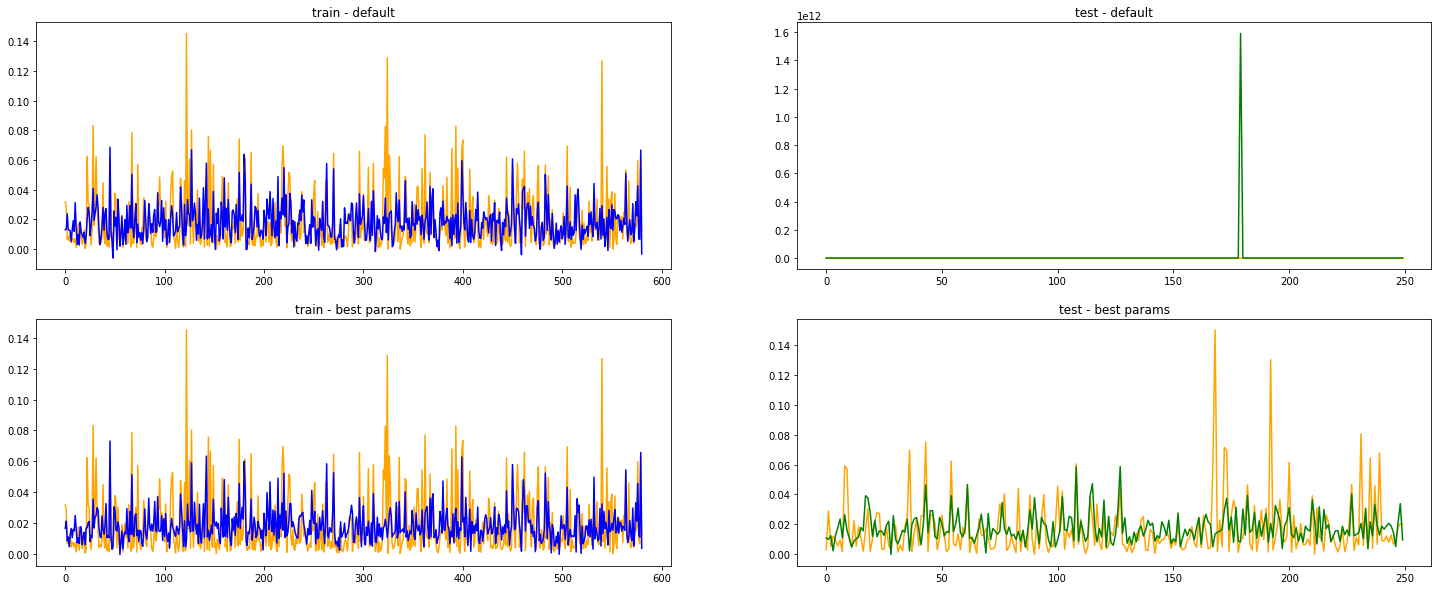

In [34]:
# Plot prédictions

plt.figure(figsize = (25, 10))
plt.subplot(2, 2, 1)
plt.plot(y_train.values, color = 'orange')
plt.plot(y_pred_train_default, color = 'blue')
plt.title('train - default')
plt.subplot(2, 2, 2)
plt.plot(y_test.values, color = 'orange')
plt.plot(y_pred_test_default, color = 'green')
plt.title('test - default')
plt.subplot(2, 2, 3)
plt.plot(y_train.values, color = 'orange')
plt.plot(y_pred_train_best, color = 'blue')
plt.title('train - best params')
plt.subplot(2, 2, 4)
plt.plot(y_test.values, color = 'orange')
plt.plot(y_pred_test_best, color = 'green')
plt.title('test - best params')

plt.show()

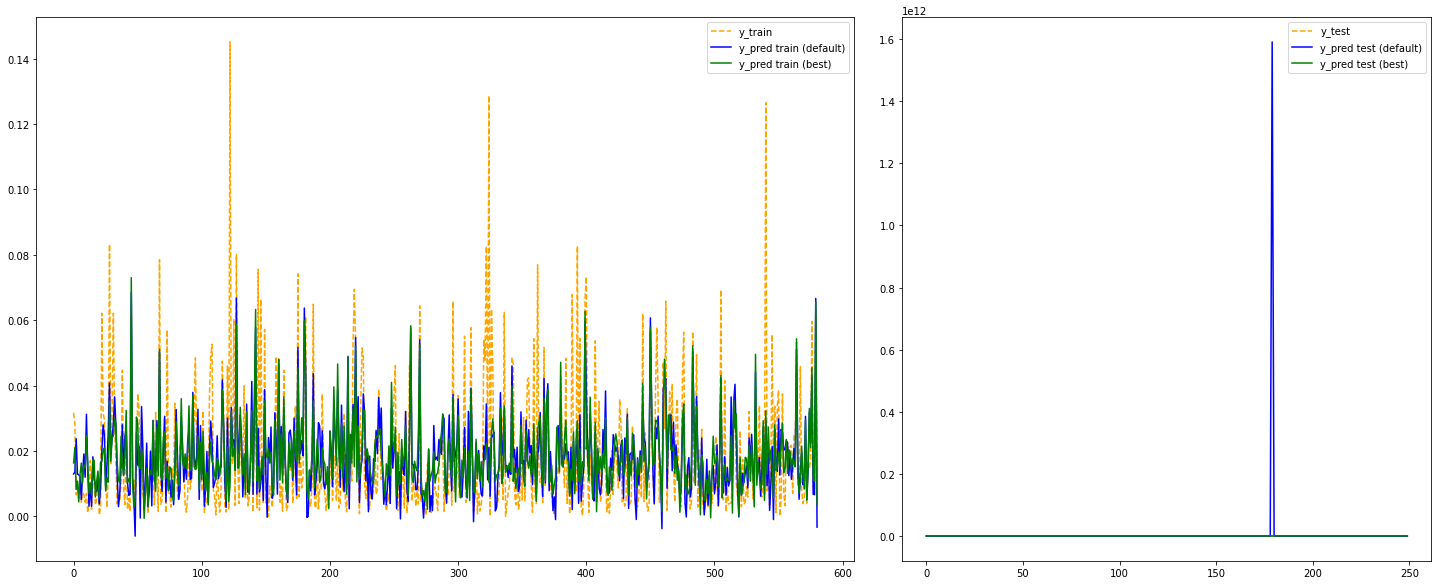

In [35]:
# Plot prédictions

plt.figure(figsize = (25, 10))

ax1 = plt.subplot2grid((1, 5), (0, 0), colspan = 3)
ax1.plot(y_train.values, color = 'orange', linestyle = '--', label = 'y_train')
ax1.plot(y_pred_train_default, color = 'blue', label = 'y_pred train (default)')
ax1.plot(y_pred_train_best, color = 'green', label = 'y_pred train (best)')
plt.legend(loc = "best")

ax2 = plt.subplot2grid((1, 5), (0, 3), colspan = 2)
ax2.plot(y_test.values, color = 'orange', linestyle = '--', label = 'y_test')
ax2.plot(y_pred_test_default, color = 'blue', label = 'y_pred test (default)')
ax2.plot(y_pred_test_best, color = 'green', label = 'y_pred test (best)')
plt.legend(loc = "best")

plt.show()

In [36]:
########## EVALUATION ##########

model_evaluation(model_name = 'Linear regression', 
                 model_type = 'Best', 
                 y_train = y_train, 
                 y_test = y_test, 
                 y_predtrain = y_pred_train_best, 
                 y_predtest = y_pred_test_best, 
                 temps = temps)

## Modèle 2 - KNeighborsRegressor

In [37]:
########## KNN Default Params ##########

# début de l'execution
start = time.time()

# Instancier le modèle
knn = KNeighborsRegressor()

# Entrainer le modèle
knn.fit(X_train, y_train)

# fin de l'execution
end = time.time()
temps = end - start

# Score
print(f'Coefficient de détermination (R2) = {knn.score(X_test, y_test)}')

# Predire
y_pred_test_default = knn.predict(X_test)
y_pred_train_default = knn.predict(X_train)

Coefficient de détermination (R2) = 0.01445249131758175


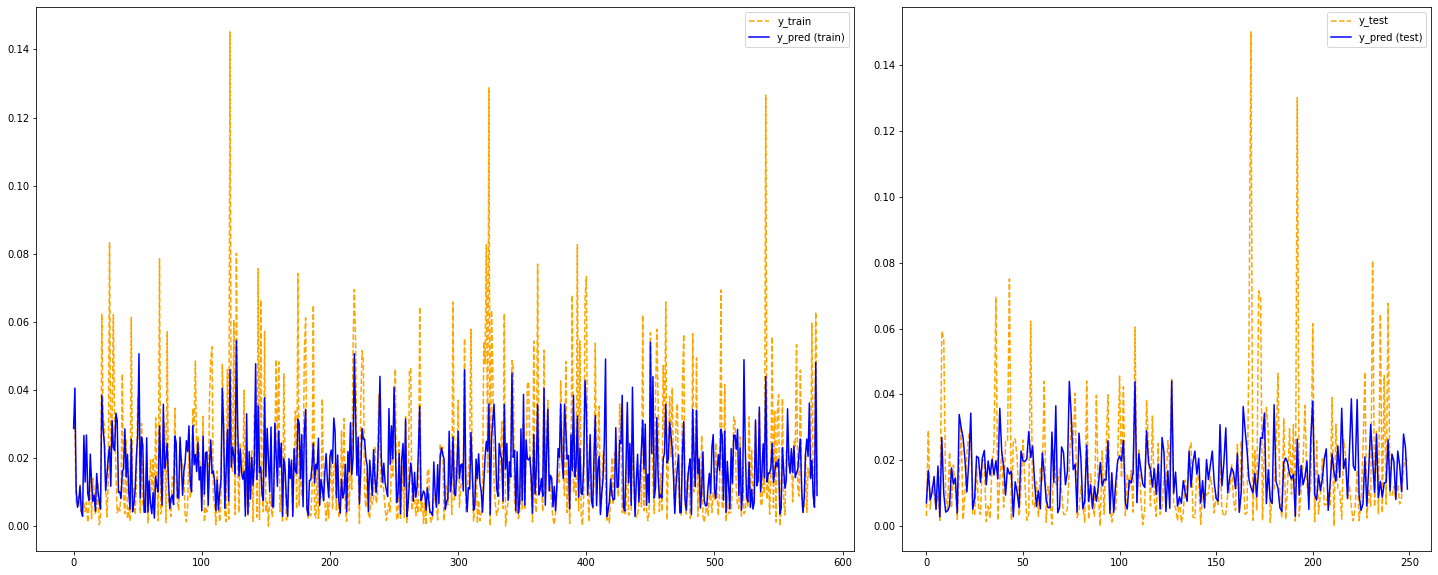

In [38]:
# Plot prédictions 

plt.figure(figsize = (25, 10))

ax1 = plt.subplot2grid((1, 5), (0, 0), colspan = 3)
ax1.plot(y_train.values, color = 'orange', linestyle = '--', label = 'y_train')
ax1.plot(y_pred_train_default, color = 'blue', label = 'y_pred (train)')
plt.legend(loc = "best")

ax2 = plt.subplot2grid((1, 5), (0, 3), colspan = 2)
ax2.plot(y_test.values, color = 'orange', linestyle = '--', label = 'y_test')
ax2.plot(y_pred_test_default, color = 'blue', label = 'y_pred (test)')
plt.legend(loc = "best")

plt.show()

In [39]:
########## EVALUATION ##########

model_evaluation(model_name = 'KNN', 
                 model_type = 'Default', 
                 y_train = y_train, 
                 y_test = y_test, 
                 y_predtrain = y_pred_train_default, 
                 y_predtest = y_pred_test_default, 
                 temps = temps)

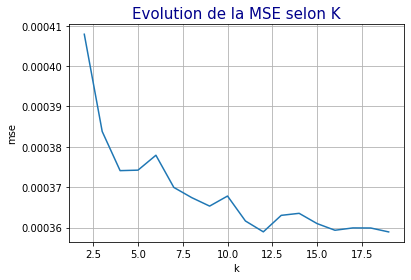

In [40]:
# Compute error according to K

k_value = []
MSE = []
for i in range(2, 20):
    k_value.append(i)
    knn = KNeighborsRegressor(n_neighbors = i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    knn_mse = mean_squared_error(y_test, y_pred)
    MSE.append(knn_mse)

plt.figure()
plt.grid()
plt.plot(k_value, MSE)
plt.title ("Evolution de la MSE selon K", fontsize = 15, color = 'darkblue')
plt.xlabel('k')
plt.ylabel('mse')
plt.show()

In [41]:
%%time

########## GRIDSEARCH CV ##########

# début de l'execution
start = time.time()

# Modèle
knn = KNeighborsRegressor()

# Paramètres
# avec algo et leaf size -> plus de 7h

param_grid = [{
    'n_neighbors': list(range(1, 51)), # default = 5
    'weights': ['uniform', 'distance'], # default = ’uniform’
    #'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'], # default = ’auto’
    #'leaf_size' : list(range(20, 41)), # default = 30
    'p' : [1, 2, 3, 4, 5], # default = 2
    'metric': ['euclidean', 'manhattan', 'minkowski'], # default = ’minkowski’
    'n_jobs' : [1, 2, 3, 4, 5] # default = None
}]

# Grid Search CV
grid = GridSearchCV(knn,
                    param_grid,
                    scoring = 'neg_mean_squared_error',
                    cv = 5,
                    verbose = 1,
                    n_jobs = -1
                   )

# On entraîne la grille 
grid.fit(X_train, y_train)

# fin de l'execution
end = time.time()
temps = end - start

# Meilleur score obtenu: best_score_
print(f'\nBest score = {grid.best_score_}')

# Optimal hyperparameters: best_params_
display(grid.best_params_)

# Sauvegarder le meilleur modèle
best_knn = grid.best_estimator_

# Tester le meilleur modèle sur données test
print(f'Coefficient de détermination (R2) = {best_knn.score(X_test, y_test)}\n')

# Predire
y_pred_test_best = best_knn.predict(X_test)
y_pred_train_best = best_knn.predict(X_train)

Fitting 5 folds for each of 7500 candidates, totalling 37500 fits

Best score = -0.00034298229932993446


{'metric': 'manhattan',
 'n_jobs': 1,
 'n_neighbors': 49,
 'p': 1,
 'weights': 'distance'}

Coefficient de détermination (R2) = 0.0972679166149959

CPU times: user 4.94 s, sys: 599 ms, total: 5.54 s
Wall time: 55.6 s


Quantités de données à utiliser pour l'entrainement (10 lots): [ 92 134 175 216 257 299 340 381 422 464]


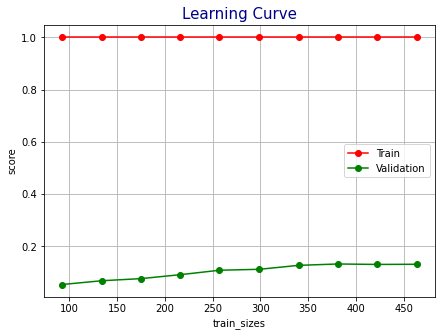

In [42]:
# Courbe d'apprentissage (learning curve)
# montre l'évolution des performances du modèle en fonction de la quantité de données qu'on lui fournit

N, train_score, val_score = learning_curve(best_knn, X_train, y_train, train_sizes = np.linspace(0.2, 1.0, 10), cv = 5)

# Train sizes
print(f"Quantités de données à utiliser pour l'entrainement (10 lots): {N}")

# Learning curve
plt.figure(figsize = (7,5))
plt.grid()
plt.plot(N, train_score.mean(axis = 1), 'o-', color = 'r', label = 'Train')
plt.plot(N, val_score.mean(axis = 1), 'o-', color  = 'g', label = 'Validation')
plt.title ('Learning Curve', fontsize = 15, color = 'darkblue')
plt.legend(loc = 'best')
plt.xlabel('train_sizes')
plt.ylabel('score')
plt.show()

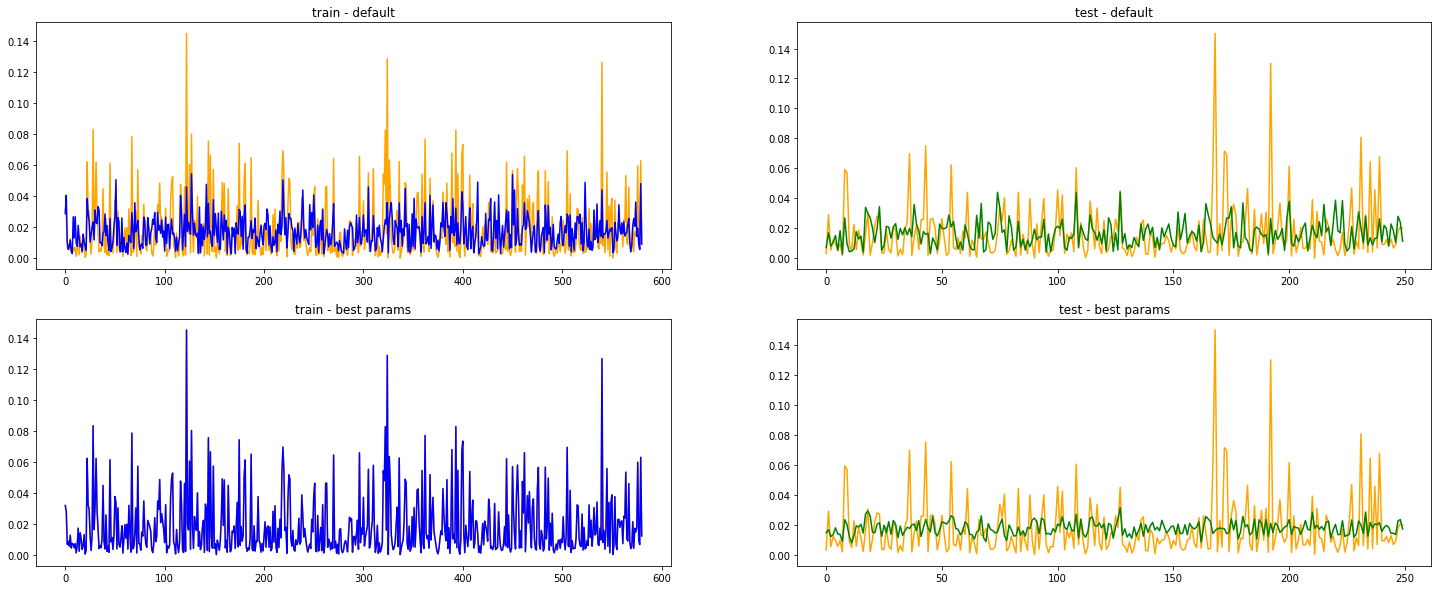

In [43]:
# Plot prédictions

plt.figure(figsize = (25, 10))
plt.subplot(2, 2, 1)
plt.plot(y_train.values, color = 'orange')
plt.plot(y_pred_train_default, color = 'blue')
plt.title('train - default')
plt.subplot(2, 2, 2)
plt.plot(y_test.values, color = 'orange')
plt.plot(y_pred_test_default, color = 'green')
plt.title('test - default')
plt.subplot(2, 2, 3)
plt.plot(y_train.values, color = 'orange')
plt.plot(y_pred_train_best, color = 'blue')
plt.title('train - best params')
plt.subplot(2, 2, 4)
plt.plot(y_test.values, color = 'orange')
plt.plot(y_pred_test_best, color = 'green')
plt.title('test - best params')

plt.show()

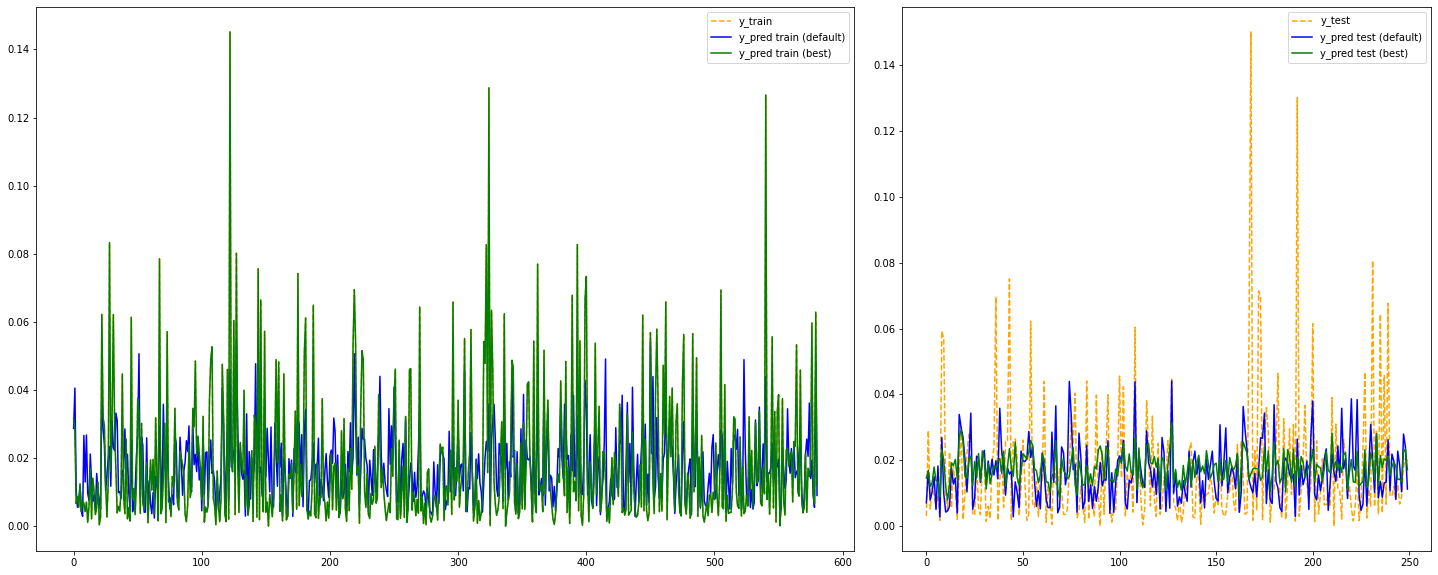

In [44]:
# Plot prédictions

plt.figure(figsize = (25, 10))

ax1 = plt.subplot2grid((1, 5), (0, 0), colspan = 3)
ax1.plot(y_train.values, color = 'orange', linestyle = '--', label = 'y_train')
ax1.plot(y_pred_train_default, color = 'blue', label = 'y_pred train (default)')
ax1.plot(y_pred_train_best, color = 'green', label = 'y_pred train (best)')
plt.legend(loc = "best")

ax2 = plt.subplot2grid((1, 5), (0, 3), colspan = 2)
ax2.plot(y_test.values, color = 'orange', linestyle = '--', label = 'y_test')
ax2.plot(y_pred_test_default, color = 'blue', label = 'y_pred test (default)')
ax2.plot(y_pred_test_best, color = 'green', label = 'y_pred test (best)')
plt.legend(loc = "best")

plt.show()

In [45]:
########## EVALUATION ##########

model_evaluation(model_name = 'KNN', 
                 model_type = 'Best', 
                 y_train = y_train, 
                 y_test = y_test, 
                 y_predtrain = y_pred_train_best, 
                 y_predtest = y_pred_test_best, 
                 temps = temps)

## Modèle 3 - Support Vector Machine Regressor

In [46]:
########## SVR Default Params ##########

# début de l'execution
start = time.time()

# Instancier le modèle
svr = SVR()

# Entrainer le modèle
svr.fit(X_train, y_train)

# fin de l'execution
end = time.time()
temps = end - start

# Score
print(f'Coefficient de détermination (R2) = {svr.score(X_test, y_test)}')

# Predire
y_pred_test_default = svr.predict(X_test)
y_pred_train_default = svr.predict(X_train)

Coefficient de détermination (R2) = -8.106247002190722


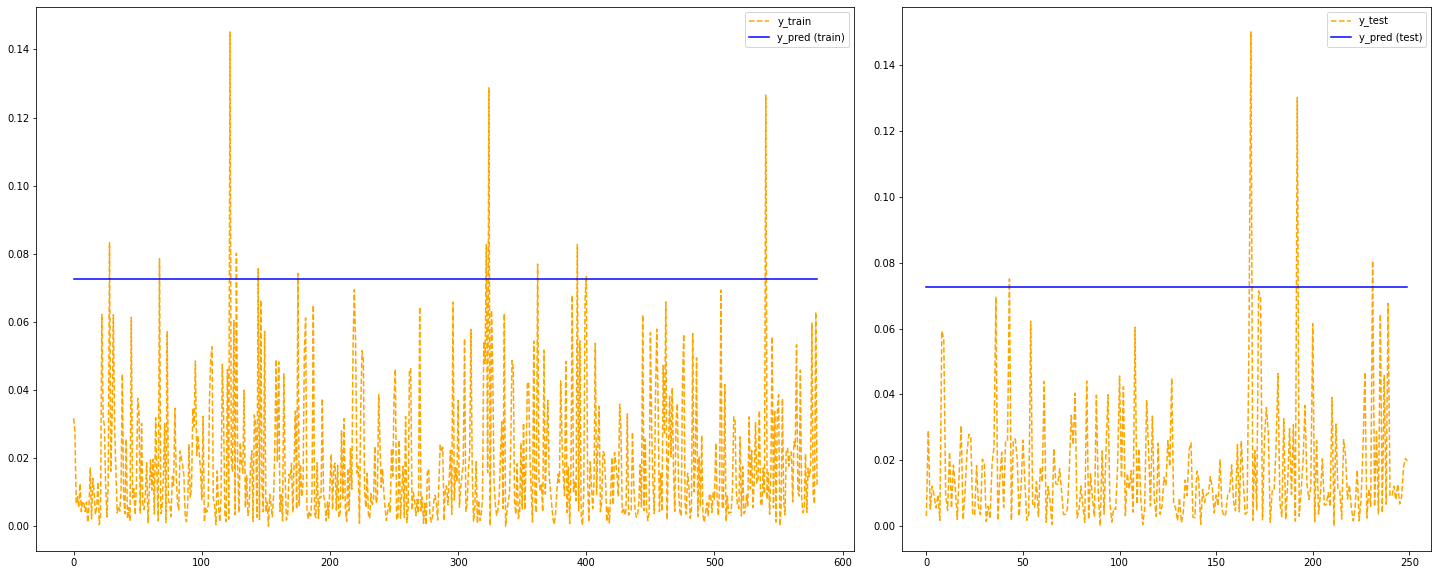

In [47]:
# Plot prédictions

plt.figure(figsize = (25, 10))

ax1 = plt.subplot2grid((1, 5), (0, 0), colspan = 3)
ax1.plot(y_train.values, color = 'orange', linestyle = '--', label = 'y_train')
ax1.plot(y_pred_train_default, color = 'blue', label = 'y_pred (train)')
plt.legend(loc = "best")

ax2 = plt.subplot2grid((1, 5), (0, 3), colspan = 2)
ax2.plot(y_test.values, color = 'orange', linestyle = '--', label = 'y_test')
ax2.plot(y_pred_test_default, color = 'blue', label = 'y_pred (test)')
plt.legend(loc = "best")

plt.show()

In [48]:
########## EVALUATION ##########

model_evaluation(model_name = 'SVR', 
                 model_type = 'Default', 
                 y_train = y_train, 
                 y_test = y_test, 
                 y_predtrain = y_pred_train_default, 
                 y_predtest = y_pred_test_default, 
                 temps = temps)

In [49]:
%%time

########## GRIDSEARCH CV ##########

# début de l'execution
start = time.time()

# Modèle
svr = SVR()

# Paramètres
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], # default = ’rbf’
    'C': [1, 5, 10], # default = 1.0
    'gamma': ['auto', 'scale'], # default = ’scale’
    'epsilon': [0, 0.01, 0.1, 0.2, 0.5, 1, 2], # default = 0.1
    'shrinking': [True, False], # default = True
    'max_iter' : [-1, 10, 100, 1000] #default = -1
}

# Grid Search CV
grid = GridSearchCV(svr, 
                    param_grid,
                    scoring = 'neg_mean_squared_error',
                    cv = 5,
                    verbose = 1,
                    n_jobs = -1
                   )

# On entraîne la grille 
grid.fit(X_train, y_train)

# fin de l'execution
end = time.time()
temps = end - start

# Meilleur score obtenu: best_score_
print(f'Best score = {grid.best_score_}')

# Optimal hyperparameters: best_params_
display(grid.best_params_) 

# Sauvegarder le meilleur modèle
best_svr = grid.best_estimator_

# Tester le meilleur modèle sur données test
print(f'Coefficient de détermination (R2) = {best_svr.score(X_test, y_test)}\n')

# Predire
y_pred_test_best = best_svr.predict(X_test)
y_pred_train_best = best_svr.predict(X_train)

Fitting 5 folds for each of 1344 candidates, totalling 6720 fits


/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucil

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucil

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/luc

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucil

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lu

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Use

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucil

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucil

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Use

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucil

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Use

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucil

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Use

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucil

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Use

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucil

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Use

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucil

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Use

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Use

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/l

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Use

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucil

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucil

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Use

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucil

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucil

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucil

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucil

/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucilerabeau/.pyenv/versions/artefact/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lucil

Best score = -0.00029552451573765665


{'C': 5,
 'epsilon': 0.01,
 'gamma': 'auto',
 'kernel': 'linear',
 'max_iter': -1,
 'shrinking': True}

Coefficient de détermination (R2) = 0.20450104937967184

CPU times: user 4.35 s, sys: 194 ms, total: 4.54 s
Wall time: 6min 22s


Quantités de données à utiliser pour l'entrainement (10 lots): [ 92 134 175 216 257 299 340 381 422 464]


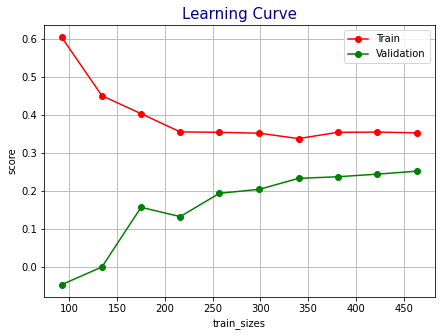

In [50]:
# Courbe d'apprentissage (learning curve)
# montre l'évolution des performances du modèle en fonction de la quantité de données qu'on lui fournit

N, train_score, val_score = learning_curve(best_svr, X_train, y_train, train_sizes = np.linspace(0.2, 1.0, 10), cv = 5)

# Train sizes
print(f"Quantités de données à utiliser pour l'entrainement (10 lots): {N}")

# Learning curve
plt.figure(figsize = (7, 5))
plt.grid()
plt.plot(N, train_score.mean(axis = 1), 'o-', color = 'r', label = 'Train')
plt.plot(N, val_score.mean(axis = 1), 'o-', color  = 'g', label = 'Validation')
plt.title ('Learning Curve', fontsize = 15, color = 'darkblue')
plt.legend(loc = 'best')
plt.xlabel('train_sizes')
plt.ylabel('score')
plt.show()

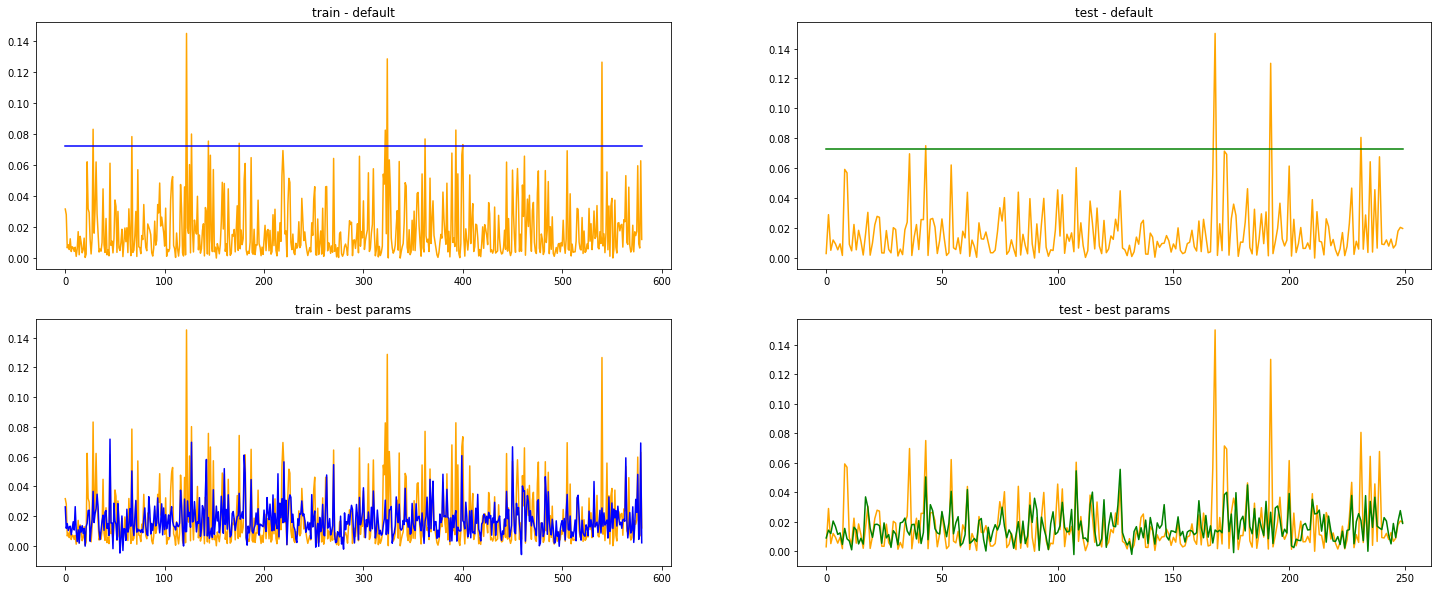

In [51]:
# Plot prédictions

plt.figure(figsize = (25, 10))
plt.subplot(2, 2, 1)
plt.plot(y_train.values, color = 'orange')
plt.plot(y_pred_train_default, color = 'blue')
plt.title('train - default')
plt.subplot(2, 2, 2)
plt.plot(y_test.values, color = 'orange')
plt.plot(y_pred_test_default, color = 'green')
plt.title('test - default')
plt.subplot(2, 2, 3)
plt.plot(y_train.values, color = 'orange')
plt.plot(y_pred_train_best, color = 'blue')
plt.title('train - best params')
plt.subplot(2, 2, 4)
plt.plot(y_test.values, color = 'orange')
plt.plot(y_pred_test_best, color = 'green')
plt.title('test - best params')

plt.show()

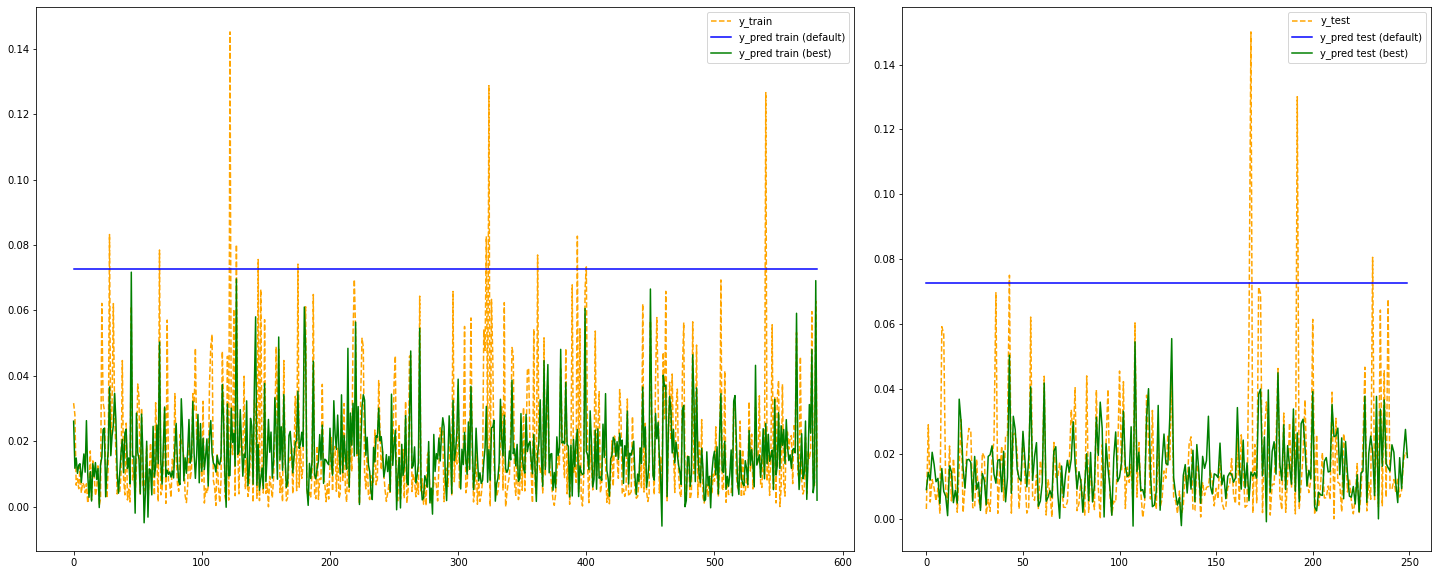

In [52]:
# Plot prédictions

plt.figure(figsize = (25, 10))

ax1 = plt.subplot2grid((1, 5), (0, 0), colspan = 3)
ax1.plot(y_train.values, color = 'orange', linestyle = '--', label = 'y_train')
ax1.plot(y_pred_train_default, color = 'blue', label = 'y_pred train (default)')
ax1.plot(y_pred_train_best, color = 'green', label = 'y_pred train (best)')
plt.legend(loc = "best")

ax2 = plt.subplot2grid((1, 5), (0, 3), colspan = 2)
ax2.plot(y_test.values, color = 'orange', linestyle = '--', label = 'y_test')
ax2.plot(y_pred_test_default, color = 'blue', label = 'y_pred test (default)')
ax2.plot(y_pred_test_best, color = 'green', label = 'y_pred test (best)')
plt.legend(loc = "best")

plt.show()

In [53]:
########## EVALUATION ##########

model_evaluation(model_name = 'SVR', 
                 model_type = 'Best', 
                 y_train = y_train, 
                 y_test = y_test, 
                 y_predtrain = y_pred_train_best, 
                 y_predtest = y_pred_test_best, 
                 temps = temps)

## Modèle 4 - Random Forest Regressor

In [54]:
########## Random Forest Regressor Default Params ##########

# début de l'execution
start = time.time()

# Instancier le modèle
forest = RandomForestRegressor()

# Entrainer le modèle
forest.fit(X_train, y_train)

# fin de l'execution
end = time.time()
temps = end - start

# Score
print(f'Coefficient de détermination (R2) = {forest.score(X_test, y_test)}')

# Predire
y_pred_test_default = forest.predict(X_test)
y_pred_train_default = forest.predict(X_train)

Coefficient de détermination (R2) = 0.2314622018021013


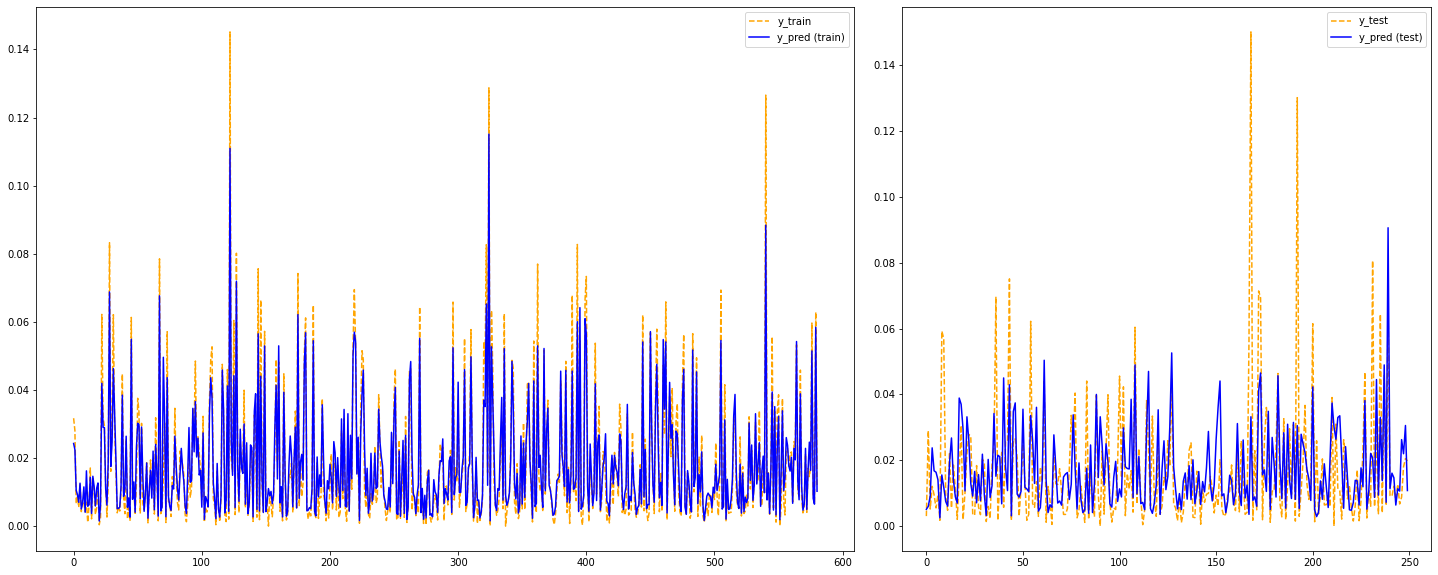

In [55]:
# Plot prédictions

plt.figure(figsize = (25, 10))

ax1 = plt.subplot2grid((1, 5), (0, 0), colspan = 3)
ax1.plot(y_train.values, color = 'orange', linestyle = '--', label = 'y_train')
ax1.plot(y_pred_train_default, color = 'blue', label = 'y_pred (train)')
plt.legend(loc = "best")

ax2 = plt.subplot2grid((1, 5), (0, 3), colspan = 2)
ax2.plot(y_test.values, color = 'orange', linestyle = '--', label = 'y_test')
ax2.plot(y_pred_test_default, color = 'blue', label = 'y_pred (test)')
plt.legend(loc = "best")

plt.show()

In [56]:
########## EVALUATION ##########

model_evaluation(model_name = 'Random Forest Regressor', 
                 model_type = 'Default', 
                 y_train = y_train, 
                 y_test = y_test, 
                 y_predtrain = y_pred_train_default, 
                 y_predtest = y_pred_test_default, 
                 temps = temps)

In [57]:
%%time

########## GRIDSEARCH CV ##########

start = time.time()

# Modèle
forest = RandomForestRegressor()

# Paramètres
param_grid = [
    {'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100], # default = 100
     #'criterion' : ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'], # default = ”squared_error”
     'max_depth' : [5, 10, 15, 25, 50, None], # default = None
     'min_samples_split' : [2, 5, 10], # default = 2
     #'min_weight_fraction_leaf' : [0.0], # default = 0.0
     'max_features': ['auto', 'sqrt', 'log2', None], # default = 1.0
     #'max_leaf_nodes': [None], # default = None
     #'min_impurity_decrease': [0.0], # default = 0.0
     'bootstrap': [True, False], # default = True
     #'oob_score': [False], # default = False - pas assez d'arbres pour avoir un OOB score fiable
     #'n_jobs': [None], # default = None
     #'random_state': [None], # default = None
     #'warm_start': [True, False], # default = False
     #'ccp_alpha': [0.0], # default = 0.0
     #'max_samples': [None] # default = None
  }]

# Grid search CV
grid = GridSearchCV(forest, 
                    param_grid,
                    scoring = 'neg_mean_squared_error',
                    cv = 5,
                    verbose = 1,
                    n_jobs = -1
                   )

# On entraîne la grille 
grid.fit(X_train, y_train)

# fin de l'execution
end = time.time()
temps = end - start

# Meilleur score obtenu: best_score_
print(f'\nBest score = {grid.best_score_}')

# Optimal hyperparameters: best_params_
display(grid.best_params_) 

# Sauvegarder le meilleur modèle
best_forest = grid.best_estimator_

# Tester le meilleur modèle sur données test
print(f'Coefficient de détermination (R2) = {best_forest.score(X_test, y_test)}\n')

# Predire
y_pred_test_best = best_forest.predict(X_test)
y_pred_train_best = best_forest.predict(X_train)

Fitting 5 folds for each of 2736 candidates, totalling 13680 fits

Best score = -0.00024395766413336622


{'bootstrap': True,
 'max_depth': 10,
 'max_features': None,
 'min_samples_split': 2,
 'n_estimators': 80}

Coefficient de détermination (R2) = 0.24366537353053164

CPU times: user 6.36 s, sys: 791 ms, total: 7.15 s
Wall time: 2min 7s


Quantités de données à utiliser pour l'entrainement (10 lots): [ 92 134 175 216 257 299 340 381 422 464]


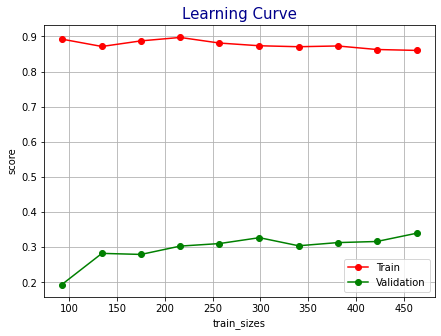

In [58]:
# Courbe d'apprentissage (learning curve)
# montre l'évolution des performances du modèle en fonction de la quantité de données qu'on lui fournit

N, train_score, val_score = learning_curve(best_forest, X_train, y_train, train_sizes = np.linspace(0.2, 1.0, 10), cv = 5)

# Train sizes
print(f"Quantités de données à utiliser pour l'entrainement (10 lots): {N}")

# Learning curve
plt.figure(figsize = (7,5))
plt.grid()
plt.plot(N, train_score.mean(axis = 1), 'o-', color = 'r', label = 'Train')
plt.plot(N, val_score.mean(axis = 1), 'o-', color  = 'g', label = 'Validation')
plt.title ('Learning Curve', fontsize = 15, color = 'darkblue')
plt.legend(loc = 'best')
plt.xlabel('train_sizes')
plt.ylabel('score')
plt.show()

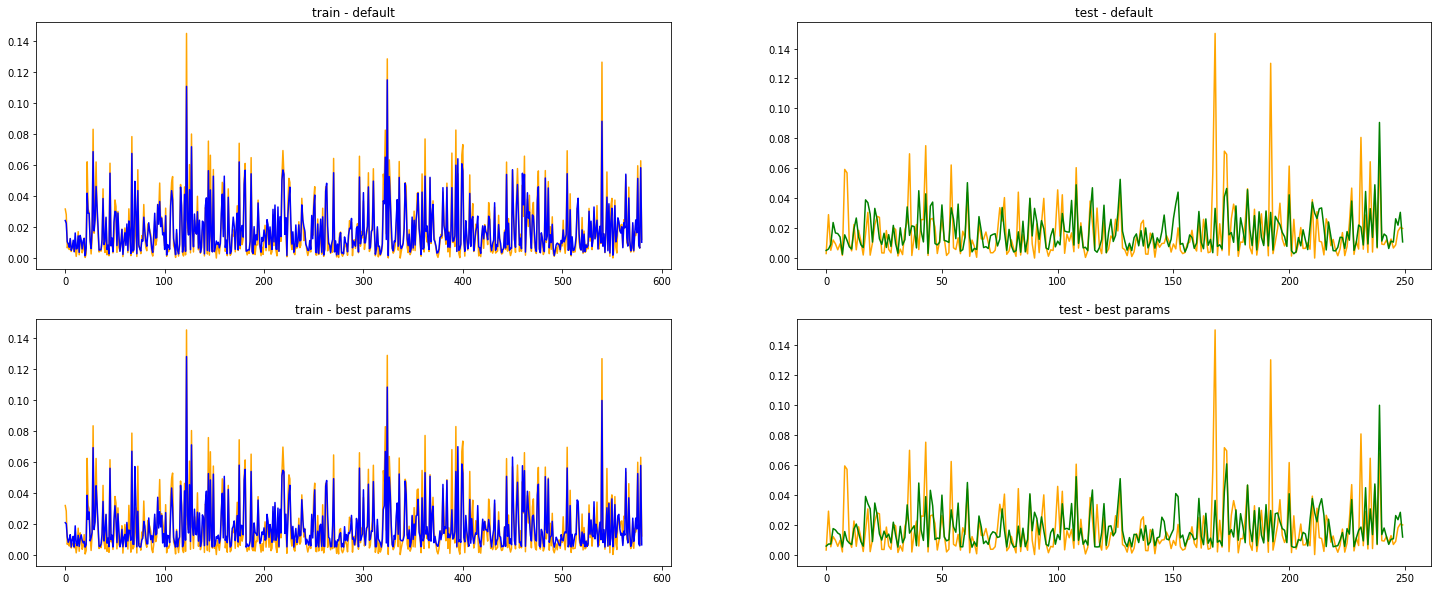

In [59]:
# Plot prédictions

plt.figure(figsize = (25, 10))
plt.subplot(2, 2, 1)
plt.plot(y_train.values, color = 'orange')
plt.plot(y_pred_train_default, color = 'blue')
plt.title('train - default')
plt.subplot(2, 2, 2)
plt.plot(y_test.values, color = 'orange')
plt.plot(y_pred_test_default, color = 'green')
plt.title('test - default')
plt.subplot(2, 2, 3)
plt.plot(y_train.values, color = 'orange')
plt.plot(y_pred_train_best, color = 'blue')
plt.title('train - best params')
plt.subplot(2, 2, 4)
plt.plot(y_test.values, color = 'orange')
plt.plot(y_pred_test_best, color = 'green')
plt.title('test - best params')

plt.show()

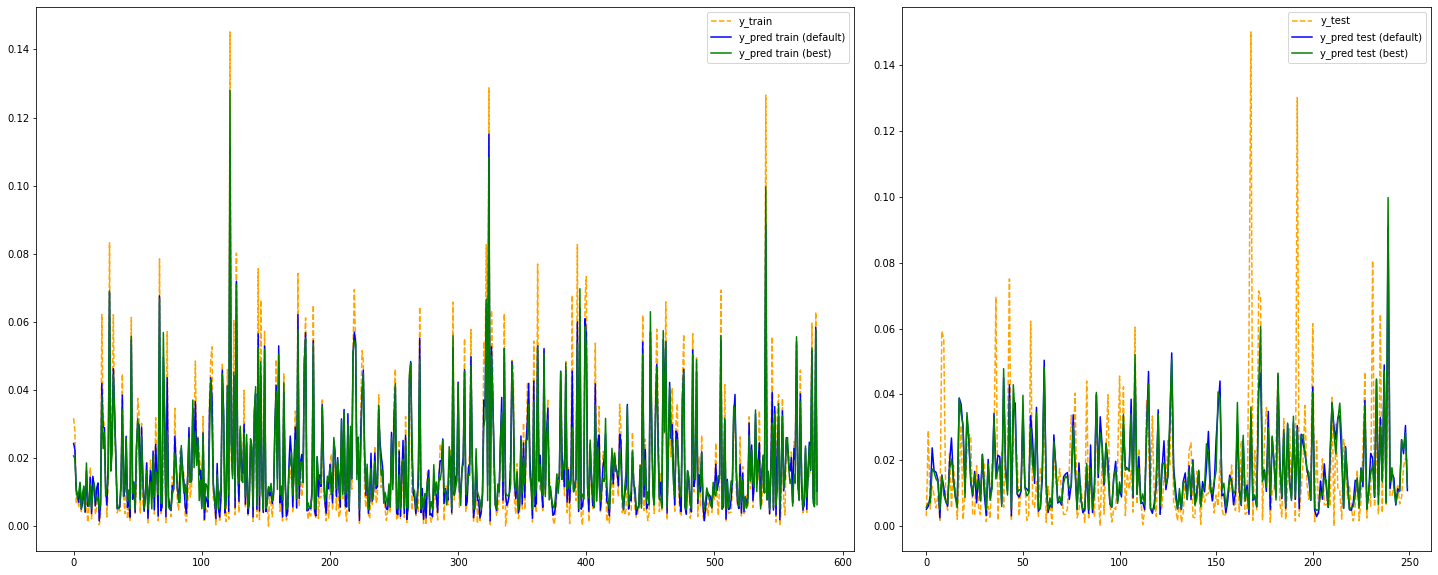

In [60]:
# Plot prédictions

plt.figure(figsize = (25, 10))

ax1 = plt.subplot2grid((1, 5), (0, 0), colspan = 3)
ax1.plot(y_train.values, color = 'orange', linestyle = '--', label = 'y_train')
ax1.plot(y_pred_train_default, color = 'blue', label = 'y_pred train (default)')
ax1.plot(y_pred_train_best, color = 'green', label = 'y_pred train (best)')
plt.legend(loc = "best")

ax2 = plt.subplot2grid((1, 5), (0, 3), colspan = 2)
ax2.plot(y_test.values, color = 'orange', linestyle = '--', label = 'y_test')
ax2.plot(y_pred_test_default, color = 'blue', label = 'y_pred test (default)')
ax2.plot(y_pred_test_best, color = 'green', label = 'y_pred test (best)')
plt.legend(loc = "best")

plt.show()

In [61]:
########## EVALUATION ##########

model_evaluation(model_name = 'Random Forest Regressor', 
                 model_type = 'Best', 
                 y_train = y_train, 
                 y_test = y_test, 
                 y_predtrain = y_pred_train_best, 
                 y_predtest = y_pred_test_best, 
                 temps = temps)

## Modèle 5 - Gradient Boosting Regressor

In [62]:
########## XGBoost Default Params ##########

# début de l'execution
start = time.time()

# Instancier le modèle
boost = GradientBoostingRegressor()

# Entrainer le modèle
boost.fit(X_train, y_train)

# fin de l'execution
end = time.time()
temps = end - start

# Score
print(f'Coefficient de détermination (R2) = {boost.score(X_test, y_test)}')

# Predire
y_pred_test_default = boost.predict(X_test)
y_pred_train_default = boost.predict(X_train)

Coefficient de détermination (R2) = 0.22300720516745987


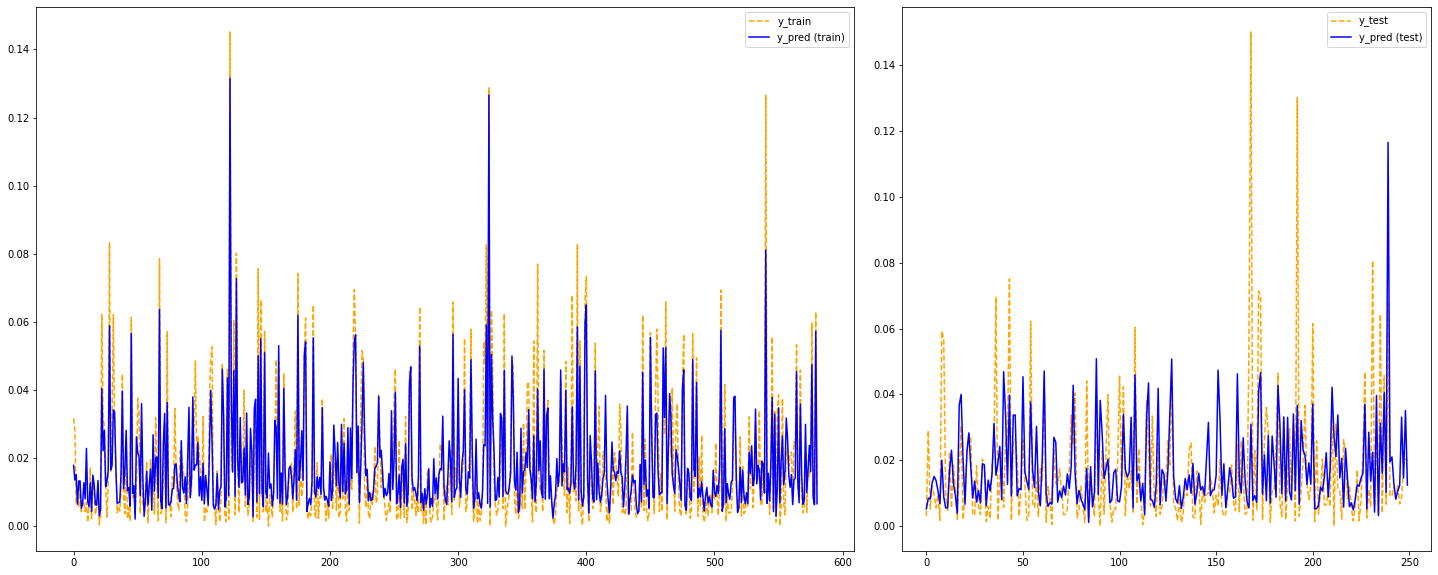

In [63]:
# Plot prédictions

plt.figure(figsize = (25, 10))

ax1 = plt.subplot2grid((1, 5), (0, 0), colspan = 3)
ax1.plot(y_train.values, color = 'orange', linestyle = '--', label = 'y_train')
ax1.plot(y_pred_train_default, color = 'blue', label = 'y_pred (train)')
plt.legend(loc = "best")

ax2 = plt.subplot2grid((1, 5), (0, 3), colspan = 2)
ax2.plot(y_test.values, color = 'orange', linestyle = '--', label = 'y_test')
ax2.plot(y_pred_test_default, color = 'blue', label = 'y_pred (test)')
plt.legend(loc = "best")

plt.show()

In [64]:
########## EVALUATION ##########

model_evaluation(model_name = 'Gradient Boosting Regressor', 
                 model_type = 'Default', 
                 y_train = y_train, 
                 y_test = y_test, 
                 y_predtrain = y_pred_train_default, 
                 y_predtest = y_pred_test_default, 
                 temps = temps)

In [65]:
%%time

########## GRIDSEARCH CV ##########

# début de l'execution
start = time.time()
time_debut = datetime.now()
time_debut_convert = time_debut.strftime('%H:%M:%S')
print(f'Début : {time_debut_convert}\n')

param_grid = {'n_estimators': [25, 50, 100, 200, 500, 1000], # default = 100
              'max_depth': [None, 1, 2, 3, 4, 6, 10, 15, 20], # default = 3
              'min_samples_split': [2, 3, 4, 5], # default = 2
              'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3], # default = 0.1
              'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'] # default = 'squared_error'
             }

grid = GridSearchCV(GradientBoostingRegressor(),
                    param_grid,
                    scoring = 'neg_mean_squared_error',
                    cv = 5,
                    verbose = 1,
                    n_jobs = -1
                   )

# On entraîne la grille 
grid.fit(X_train, y_train)

# fin de l'execution
end = time.time()
temps = end - start

# Meilleur score obtenu: best_score_
print(f'\nBest score = {grid.best_score_}')

# Optimal hyperparameters: best_params_
display(grid.best_params_) 

# Sauvegarder le meilleur modèle
best_boost = grid.best_estimator_

# Tester le meilleur modèle sur données test
print(f'Coefficient de détermination (R2) = {best_boost.score(X_test, y_test)}\n')

# Predire
y_pred_test_best = best_boost.predict(X_test)
y_pred_train_best = best_boost.predict(X_train)

Début : 21:26:00

Fitting 5 folds for each of 4320 candidates, totalling 21600 fits

Best score = -0.00023512867563412555


{'learning_rate': 0.01,
 'loss': 'absolute_error',
 'max_depth': 20,
 'min_samples_split': 2,
 'n_estimators': 1000}

Coefficient de détermination (R2) = 0.24963221217520093

CPU times: user 42.1 s, sys: 7.23 s, total: 49.4 s
Wall time: 1h 26min 8s


Quantités de données à utiliser pour l'entrainement (10 lots): [ 92 134 175 216 257 299 340 381 422 464]


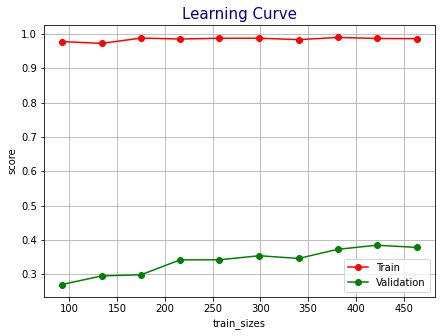

In [66]:
# Courbe d'apprentissage (learning curve)
# montre l'évolution des performances du modèle en fonction de la quantité de données qu'on lui fournit

N, train_score, val_score = learning_curve(best_boost, X_train, y_train, train_sizes = np.linspace(0.2, 1.0, 10), cv = 5)

# Train sizes
print(f"Quantités de données à utiliser pour l'entrainement (10 lots): {N}")

# Learning curve
plt.figure(figsize = (7,5))
plt.grid()
plt.plot(N, train_score.mean(axis = 1), 'o-', color = 'r', label = 'Train')
plt.plot(N, val_score.mean(axis = 1), 'o-', color  = 'g', label = 'Validation')
plt.title ('Learning Curve', fontsize = 15, color = 'darkblue')
plt.legend(loc = 'best')
plt.xlabel('train_sizes')
plt.ylabel('score')
plt.show()

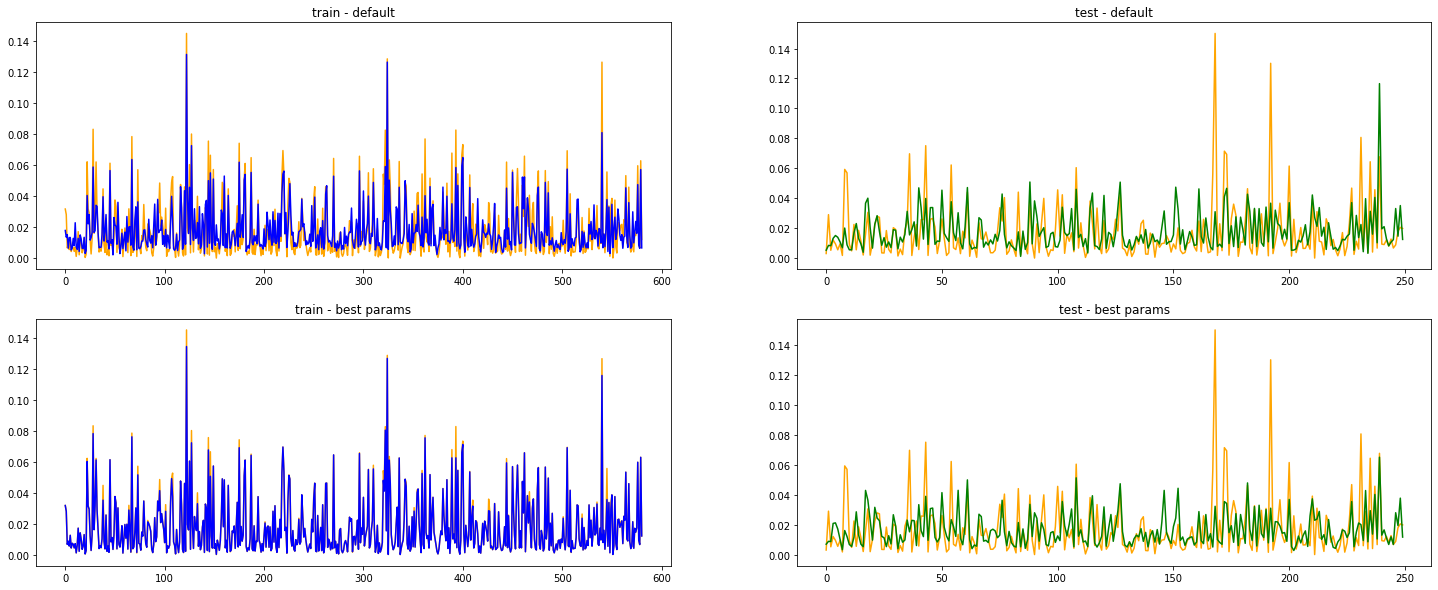

In [67]:
# Plot prédictions

plt.figure(figsize = (25, 10))
plt.subplot(2, 2, 1)
plt.plot(y_train.values, color = 'orange')
plt.plot(y_pred_train_default, color = 'blue')
plt.title('train - default')
plt.subplot(2, 2, 2)
plt.plot(y_test.values, color = 'orange')
plt.plot(y_pred_test_default, color = 'green')
plt.title('test - default')
plt.subplot(2, 2, 3)
plt.plot(y_train.values, color = 'orange')
plt.plot(y_pred_train_best, color = 'blue')
plt.title('train - best params')
plt.subplot(2, 2, 4)
plt.plot(y_test.values, color = 'orange')
plt.plot(y_pred_test_best, color = 'green')
plt.title('test - best params')

plt.show()

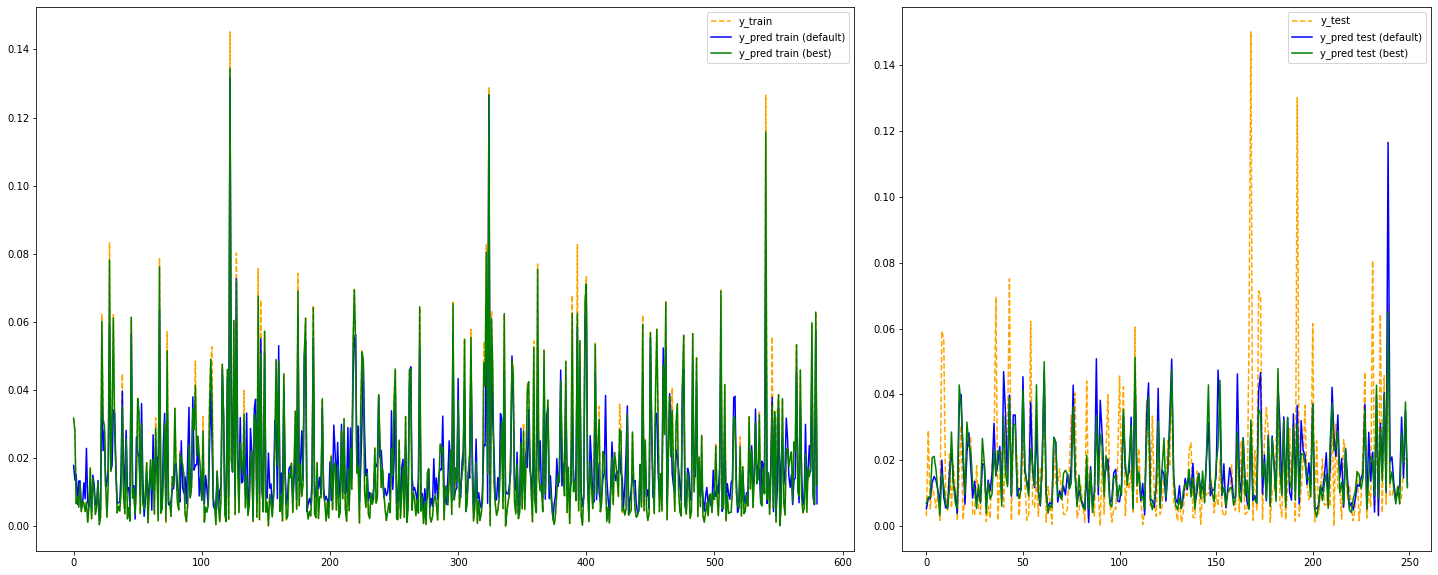

In [68]:
# Plot prédictions

plt.figure(figsize = (25, 10))

ax1 = plt.subplot2grid((1, 5), (0, 0), colspan = 3)
ax1.plot(y_train.values, color = 'orange', linestyle = '--', label = 'y_train')
ax1.plot(y_pred_train_default, color = 'blue', label = 'y_pred train (default)')
ax1.plot(y_pred_train_best, color = 'green', label = 'y_pred train (best)')
plt.legend(loc = "best")

ax2 = plt.subplot2grid((1, 5), (0, 3), colspan = 2)
ax2.plot(y_test.values, color = 'orange', linestyle = '--', label = 'y_test')
ax2.plot(y_pred_test_default, color = 'blue', label = 'y_pred test (default)')
ax2.plot(y_pred_test_best, color = 'green', label = 'y_pred test (best)')
plt.legend(loc = "best")

plt.show()

In [69]:
########## EVALUATION ##########

model_evaluation(model_name = 'Gradient Boosting Regressor', 
                 model_type = 'Best', 
                 y_train = y_train, 
                 y_test = y_test, 
                 y_predtrain = y_pred_train_best, 
                 y_predtest = y_pred_test_best, 
                 temps = temps)

## Synthèse

In [70]:
########## TABLEAU COMPARATIF ##########

x = PrettyTable()
x.add_column("Modèle", model)
x.add_column("Default/Best", default_best)
x.add_column("Temps d'execution (s)", temps_execution)
x.add_column("MAE", score_mae)
x.add_column("MSE", score_mse)
x.add_column("RMSE", score_rmse)
x.add_column("R2 train", score_r2_train)
x.add_column("R2 test", score_r2_test)

x

+-----------------------------+--------------+-----------------------+--------------+------------------------+----------------+----------+-------------------------+
|            Modèle           | Default/Best | Temps d'execution (s) |     MAE      |          MSE           |      RMSE      | R2 train |         R2 test         |
+-----------------------------+--------------+-----------------------+--------------+------------------------+----------------+----------+-------------------------+
|      Linear regression      |   Default    |         0.016         | 6363916552.4 | 1.0124858471426684e+22 | 100622355723.9 |   0.36   | -2.6663760830374774e+25 |
|      Linear regression      |     Best     |         1.661         |     0.01     |          0.0           |      0.02      |   0.3    |           0.11          |
|             KNN             |   Default    |          0.0          |     0.01     |          0.0           |      0.02      |   0.35   |           0.01          |
|             KNN             |     Best     |         55.557        |     0.01     |          0.0           |      0.02      |   1.0    |           0.1           |
|             SVR             |   Default    |         0.003         |     0.06     |          0.0           |      0.06      |   -7.5   |          -8.11          |
|             SVR             |     Best     |        382.791        |     0.01     |          0.0           |      0.02      |   0.34   |           0.2           |
|   Random Forest Regressor   |   Default    |         0.273         |     0.01     |          0.0           |      0.02      |   0.91   |           0.23          |
|   Random Forest Regressor   |     Best     |        127.004        |     0.01     |          0.0           |      0.02      |   0.85   |           0.24          |
| Gradient Boosting Regressor |   Default    |         0.083         |     0.01     |          0.0           |      0.02      |   0.8    |           0.22          |
| Gradient Boosting Regressor |     Best     |        5168.403       |     0.01     |          0.0           |      0.02      |   0.99   |           0.25          |
+-----------------------------+--------------+-----------------------+--------------+------------------------+----------------+----------+-------------------------+

In [71]:
# Faire dataframe

results = pd.DataFrame()
results['Modèle'] = model
results['Default/Best'] = default_best
results["Temps d'execution (s)"] = temps_execution
results["MAE"] = score_mae
results["MSE"] = score_mse
results["RMSE"] = score_rmse
results["R2 train"] = score_r2_train
results["R2 test"] = score_r2_test
results

Modèle Default/Best  Temps d'execution (s)  \
0            Linear regression      Default                  0.016   
1            Linear regression         Best                  1.661   
2                          KNN      Default                  0.000   
3                          KNN         Best                 55.557   
4                          SVR      Default                  0.003   
5                          SVR         Best                382.791   
6      Random Forest Regressor      Default                  0.273   
7      Random Forest Regressor         Best                127.004   
8  Gradient Boosting Regressor      Default                  0.083   
9  Gradient Boosting Regressor         Best               5168.403   

           MAE          MSE         RMSE  R2 train      R2 test  
0  6.36392e+09  1.01249e+22  1.00622e+11      0.36 -2.66638e+25  
1  1.00000e-02  0.00000e+00  2.00000e-02      0.30  1.10000e-01  
2  1.00000e-02  0.00000e+00  2.00000e-02      0.35  1.00000e-02  
3  1.00000e-02  0.00000e+00  2.00000e-02      1.00  1.00000e-01  
4  6.00000e-02  0.00000e+00  6.00000e-02     -7.50 -8.11000e+00  
5  1.00000e-02  0.00000e+00  2.00000e-02      0.34  2.00000e-01  
6  1.00000e-02  0.00000e+00  2.00000e-02      0.91  2.30000e-01  
7  1.00000e-02  0.00000e+00  2.00000e-02      0.85  2.40000e-01  
8  1.00000e-02  0.00000e+00  2.00000e-02      0.80  2.20000e-01  
9  1.00000e-02  0.00000e+00  2.00000e-02      0.99  2.50000e-01

In [72]:
results.columns

Index(['Modèle', 'Default/Best', 'Temps d'execution (s)', 'MAE', 'MSE', 'RMSE',
       'R2 train', 'R2 test'],
      dtype='object')

In [73]:
# Sort values pour rentre le résultat plus visuel
results.sort_values(['MSE', 'MAE'], ascending = False, inplace = True)

# Créer une nouvelle colonne pour faciliter visuel
results['Model'] = results['Modèle'] + ' ' + results['Default/Best']

In [77]:
# Regression linéaire par défaut -> résultat abérrant - à écarter
results_clean = results.loc[(results['Model'] != 'Linear regression Default') & (results['Model'] != 'SVR Default')]

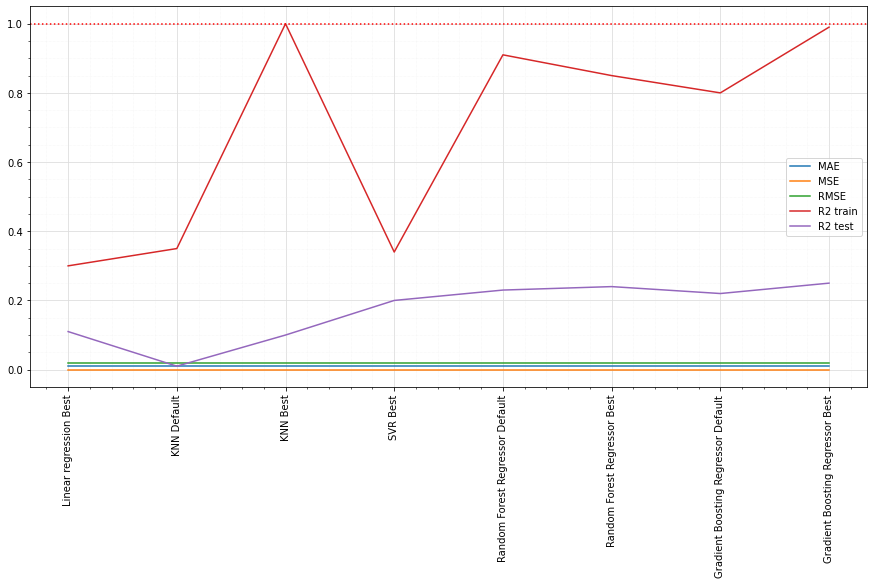

In [78]:
# plot results
plt.figure(figsize = (15, 7))
for i in results_clean.drop(['Model', 'Modèle', "Default/Best", "Temps d'execution (s)"], axis = 1).columns:
    plt.plot(results_clean['Model'], results_clean[i], label = i)
plt.axhline(y = 1, color = 'r', linestyle = ':')
plt.legend(loc = 'best')
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.xticks(rotation = 90)
plt.show()

In [ ]:
# suspection d'overfitting encore une fois (mesures d'erreur nulles et r2 train proche de 1)
# -> enlever ghge emission intensity (correlation moyenne avec l'autre target, elle même correlée avec consommation energie)
# -> augmentation de données

In [79]:
# BEST MODEL

best_model = boost

## Feature importance

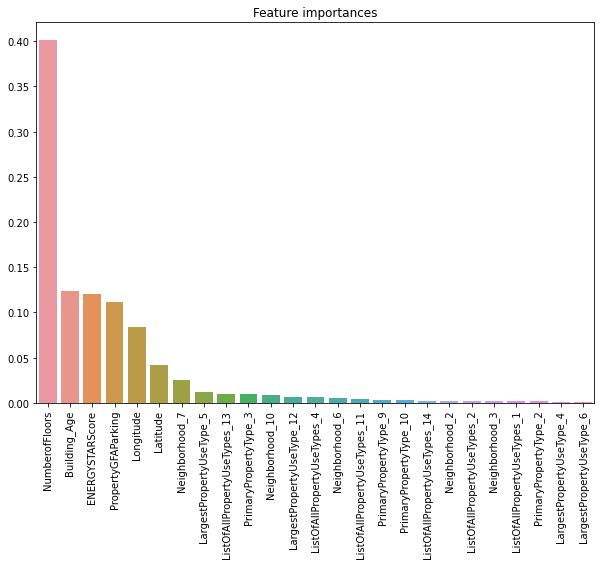

In [81]:
########## FEATURES IMPORTANTES ##########
# identifier les features importantes

# get importance
score = best_model.feature_importances_
feature = X.columns #(pour ne pas prendre l'index)

# transformer en df pour visualiser plus facilement
df_feature = pd.DataFrame()
df_feature['feature'] = feature
df_feature['score'] = score

df_feature.sort_values(['score'], ascending = False, inplace = True)

# bar plot pour visualiser les 25 features les plus importantes
plt.figure(figsize = (10, 7))
plt.title('Feature importances')
sns.barplot(x = df_feature['feature'].values[:25], y = df_feature['score'].values[:25])
plt.xticks(rotation = 90)
plt.show()